In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
import seaborn as sns
import statsmodels.api as sm
import numpy as np

In [2]:
with open('../../data/climate_data.pkl', 'rb') as f:
    data = pickle.load(f)

cities = data['cities']
stations_info = data['stations_info']

In [3]:
city_list = list(cities.keys())

In [4]:
def decompose_all_cities(cities, city_list, column='TEMP', freq='ME', period=12, plot=True):
    trends = {}

    for city in city_list:
        df = cities[city].copy()
        df['DATE'] = pd.to_datetime(df['DATE'])

        # Grupowanie do miesięcznych wartości
        monthly = df.set_index('DATE').resample(freq)[column].mean()

        # Wymuszamy pełny ciągły indeks miesięczny, uzupełniając brakujące miesiące NaN
        monthly = monthly.asfreq(freq)

        # Usuwamy NaN na potrzeby dekompozycji (STL radzi sobie z krótkimi lukami, ale nie z NaN)
        monthly_clean = monthly.dropna()

        if len(monthly_clean) < 2 * period:
            print(f"Zbyt mało danych do dekompozycji dla miasta {city}")
            continue

        # Dekompozycja STL
        stl = STL(monthly_clean, period=period, robust=True)
        res = stl.fit()

        trends[city] = res.trend

        if plot:
            plt.figure(figsize=(12, 8))
            plt.suptitle(f'Dekompozycja STL miesięczna dla {city} – {column}', fontsize=14)

            plt.subplot(4, 1, 1)
            plt.plot(monthly_clean.index, monthly_clean.values, label='Oryginalne')
            plt.legend()

            plt.subplot(4, 1, 2)
            plt.plot(res.trend.index, res.trend.values, label='Trend', color='orange')
            plt.legend()

            plt.subplot(4, 1, 3)
            plt.plot(res.seasonal.index, res.seasonal.values, label='Sezonowość', color='green')
            plt.legend()

            plt.subplot(4, 1, 4)
            plt.plot(res.resid.index, res.resid.values, label='Reszty', color='red')
            plt.legend()

            plt.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()

    return trends

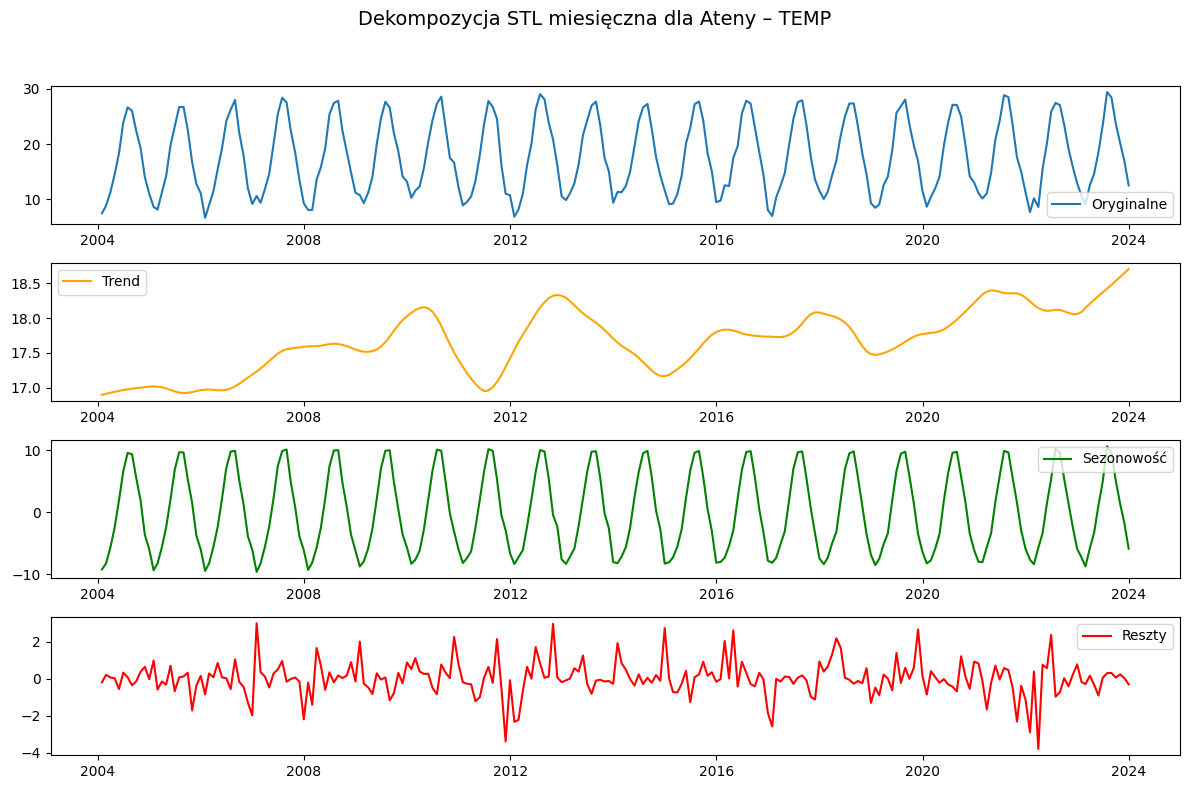

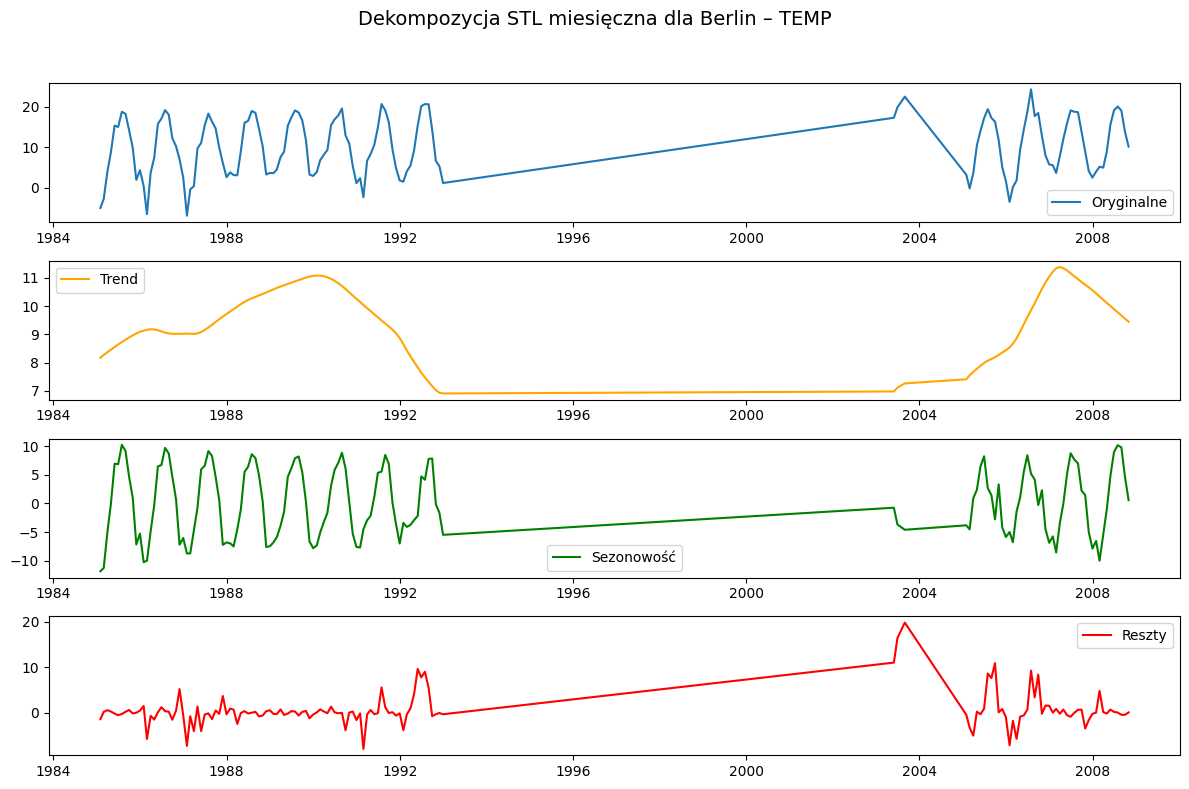

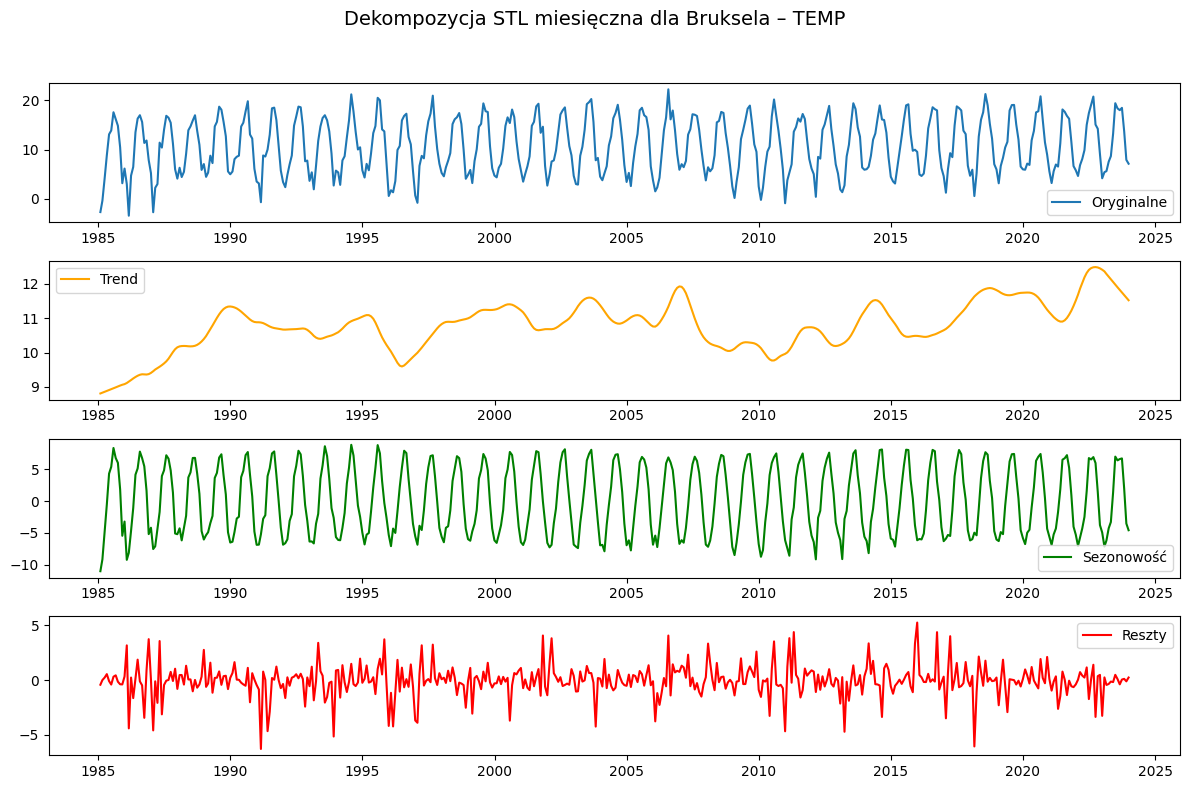

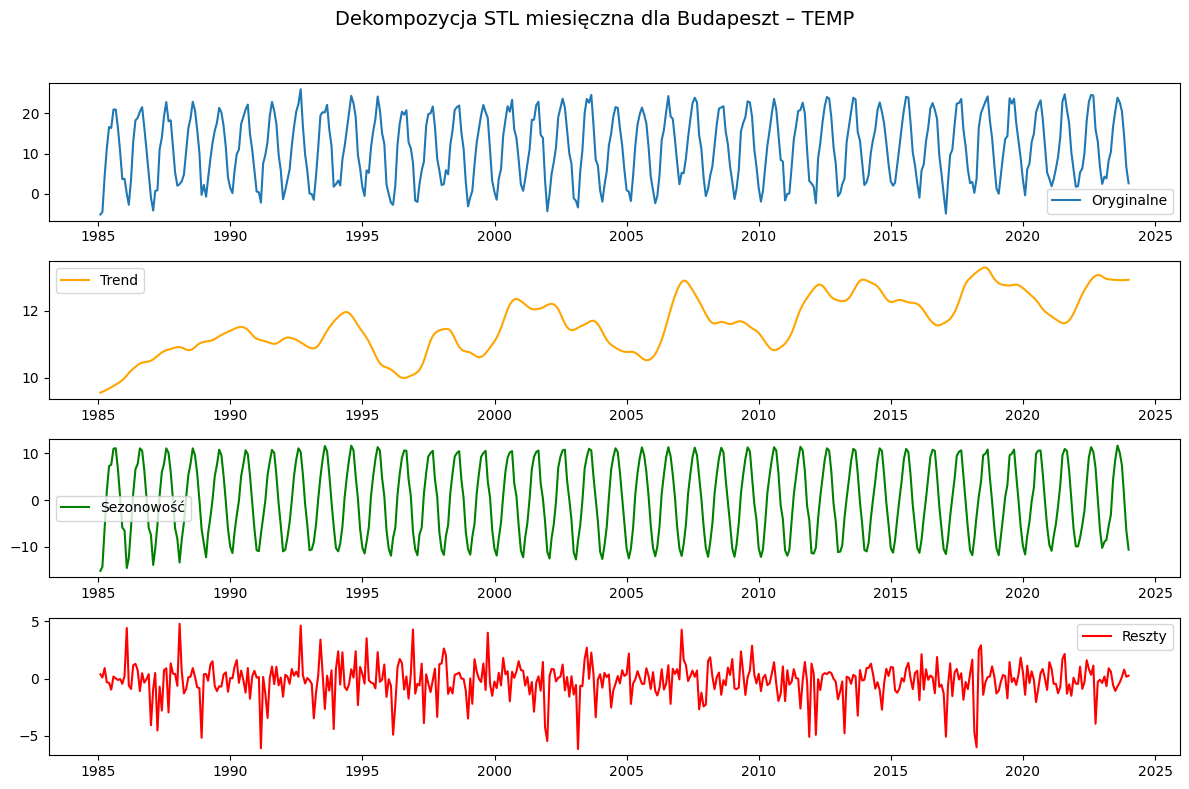

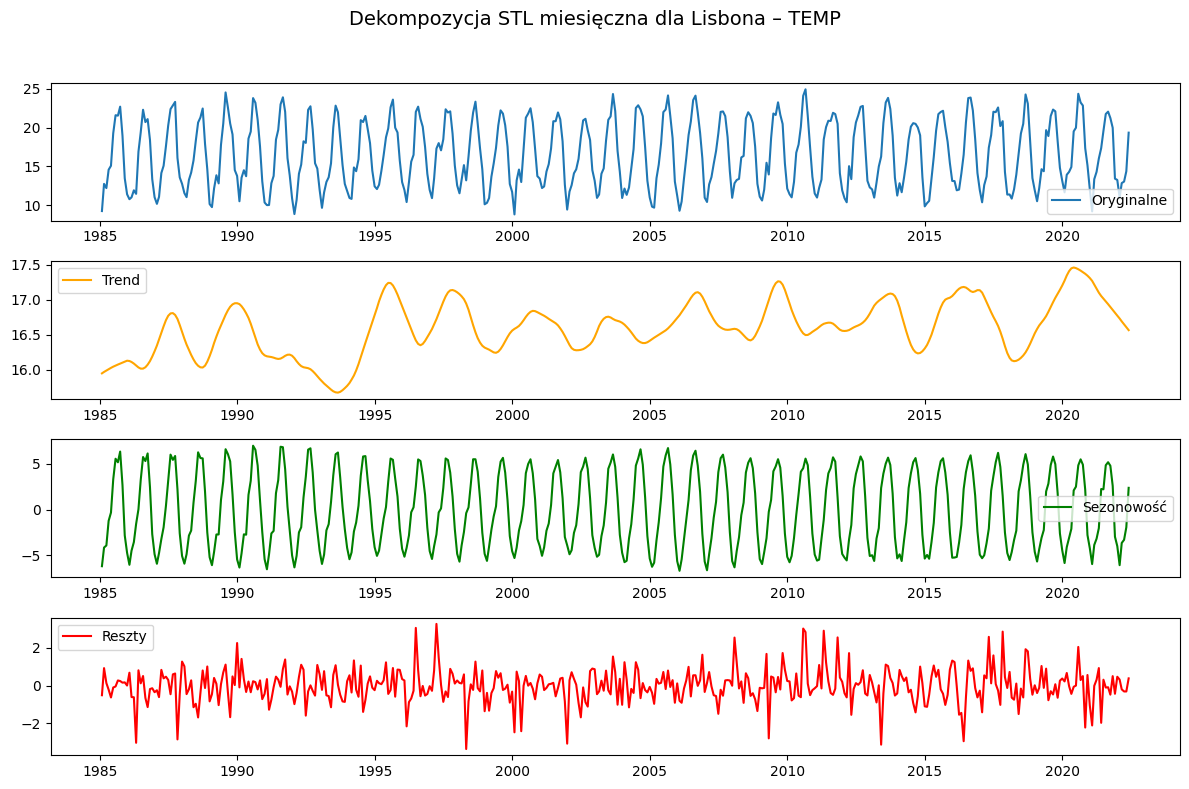

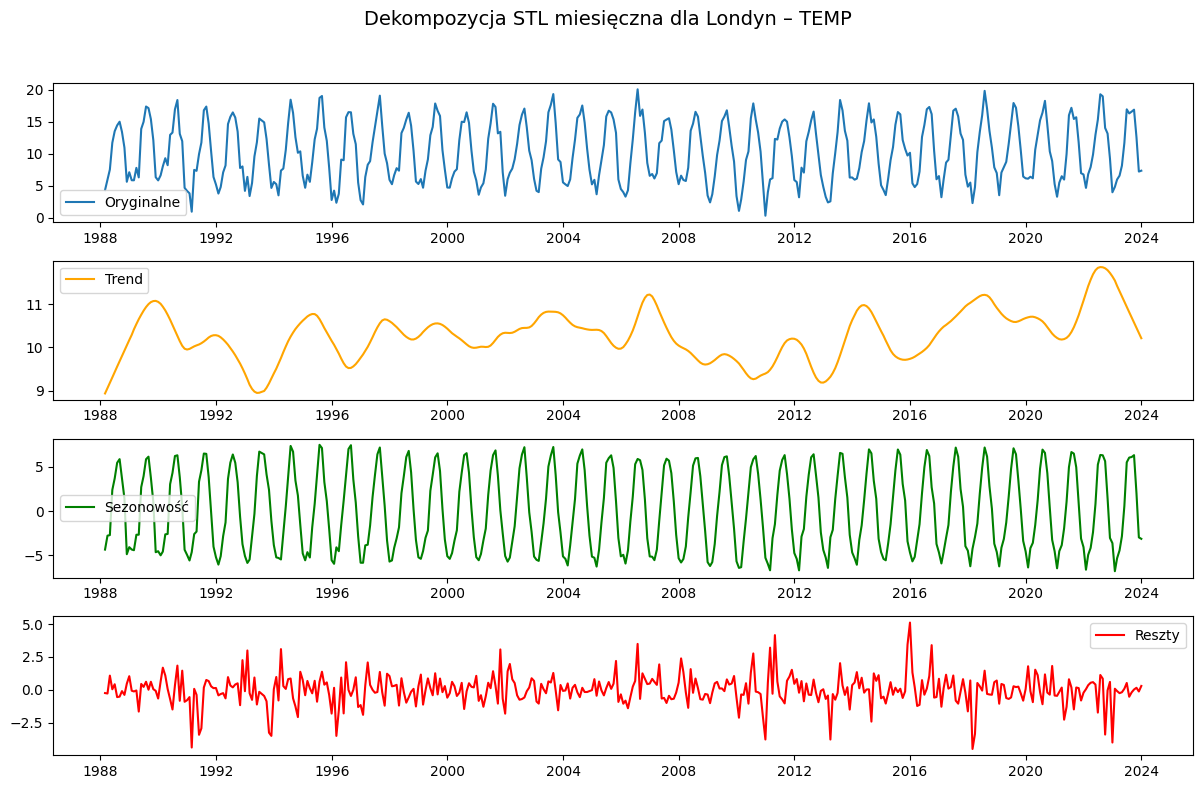

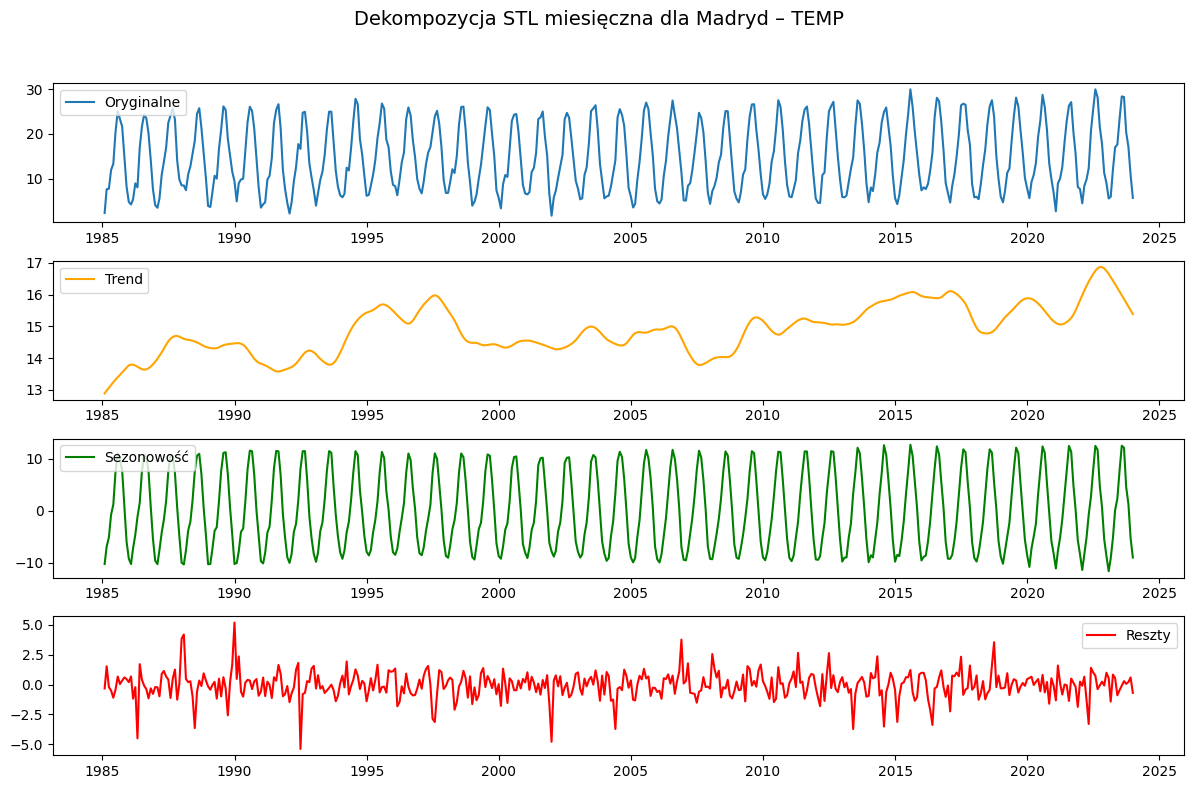

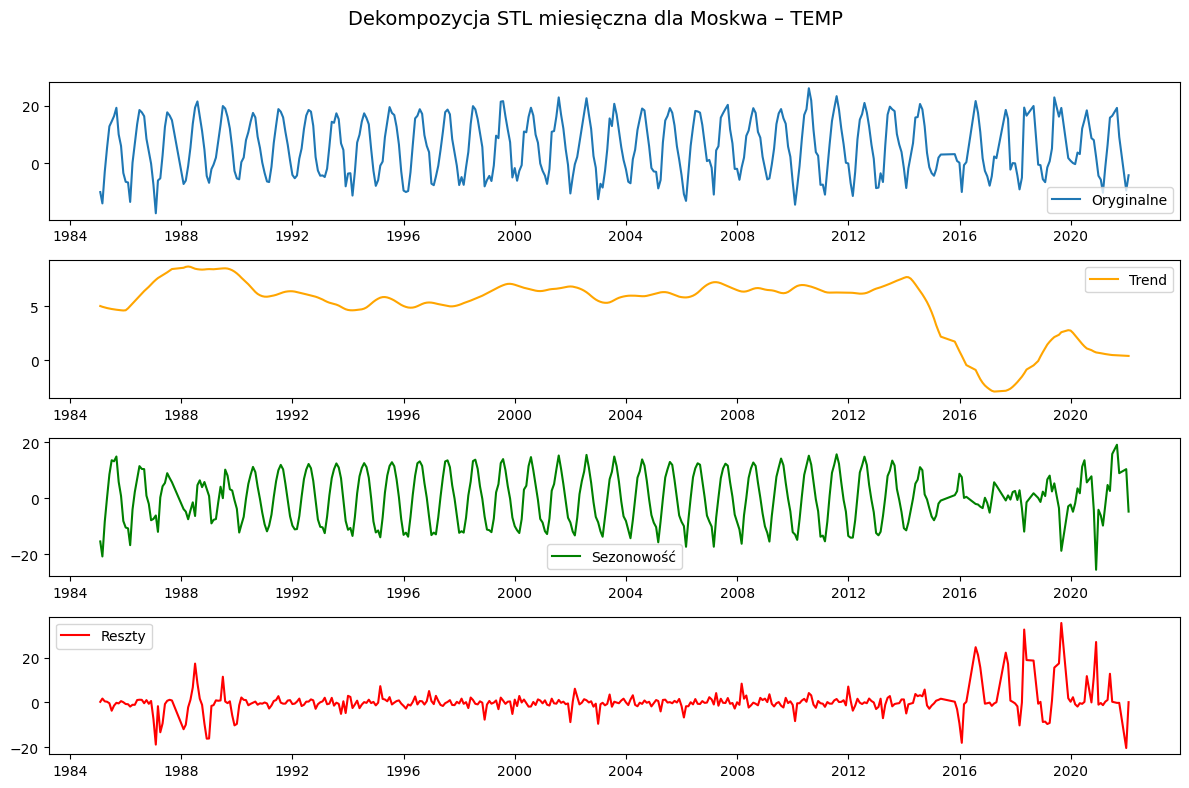

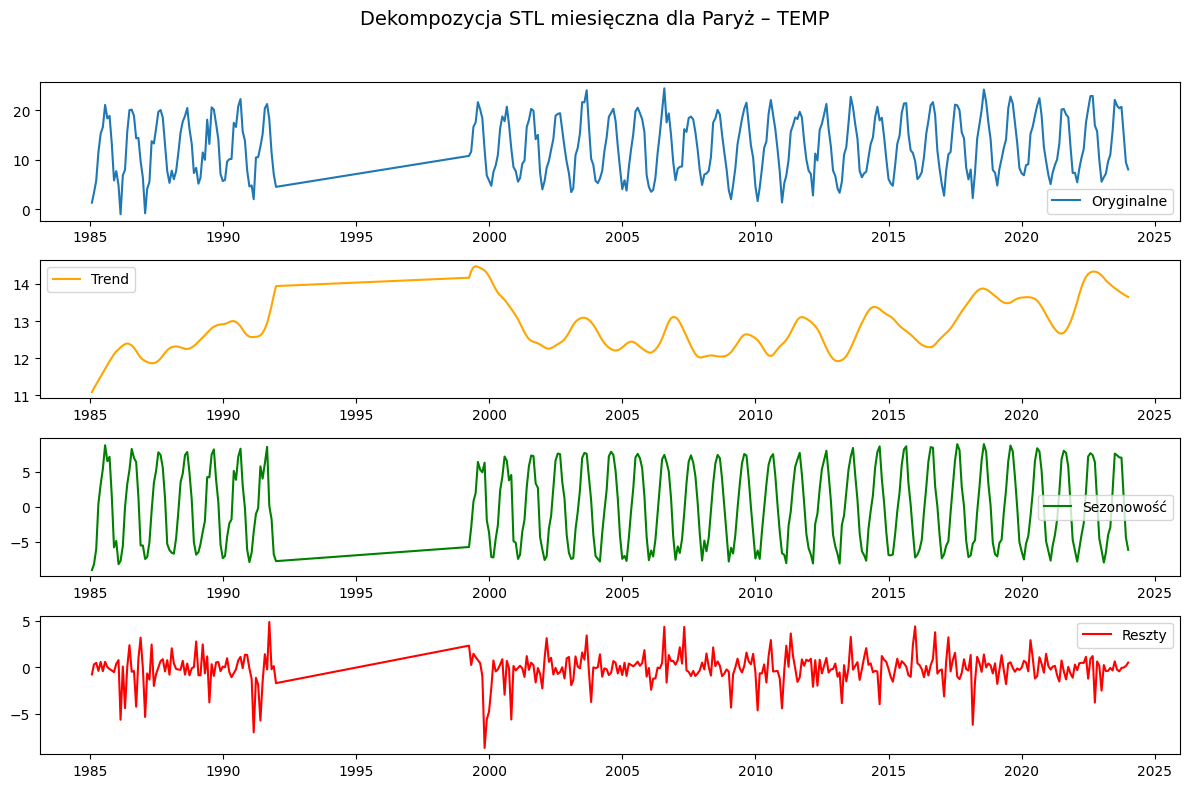

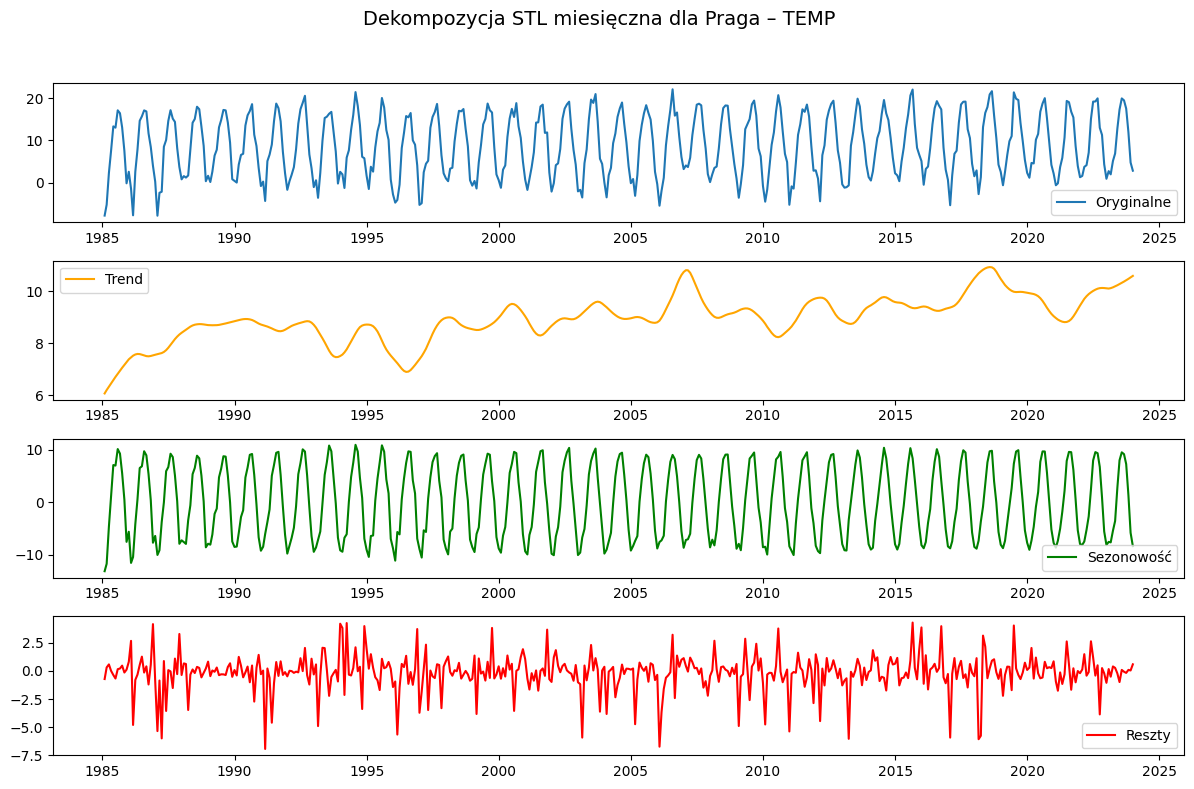

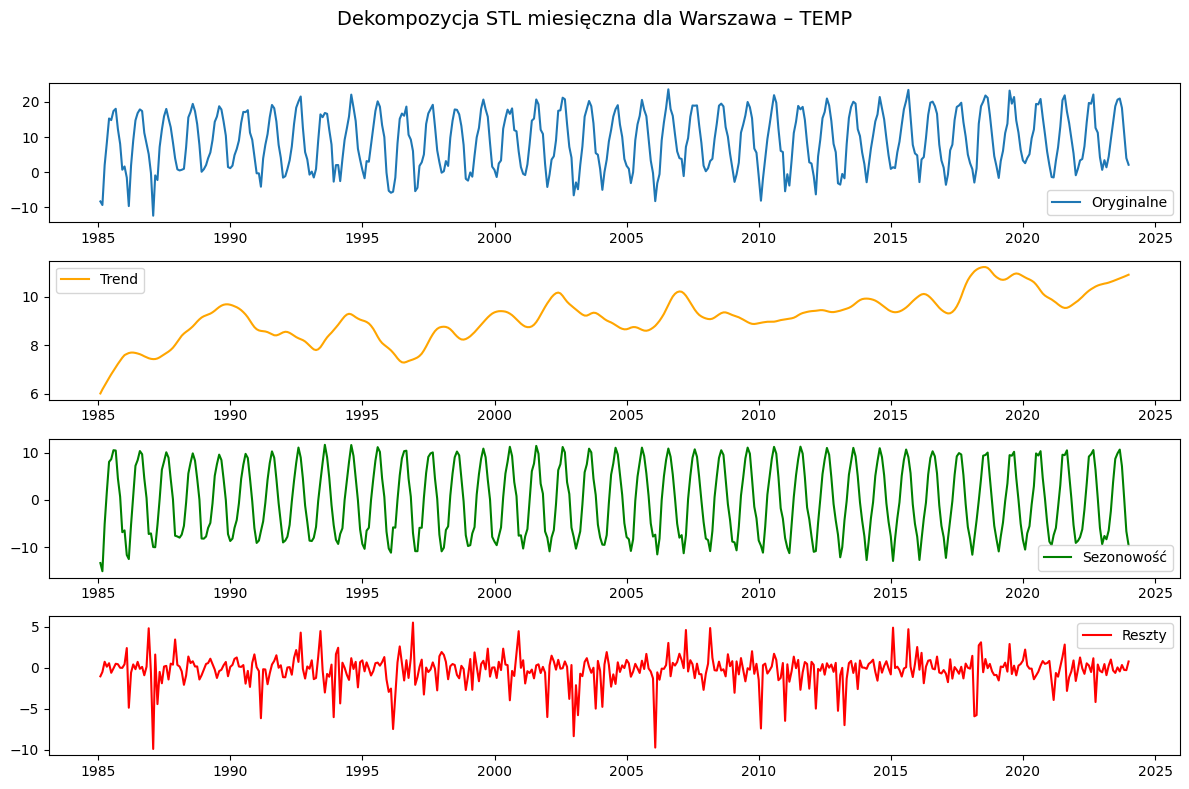

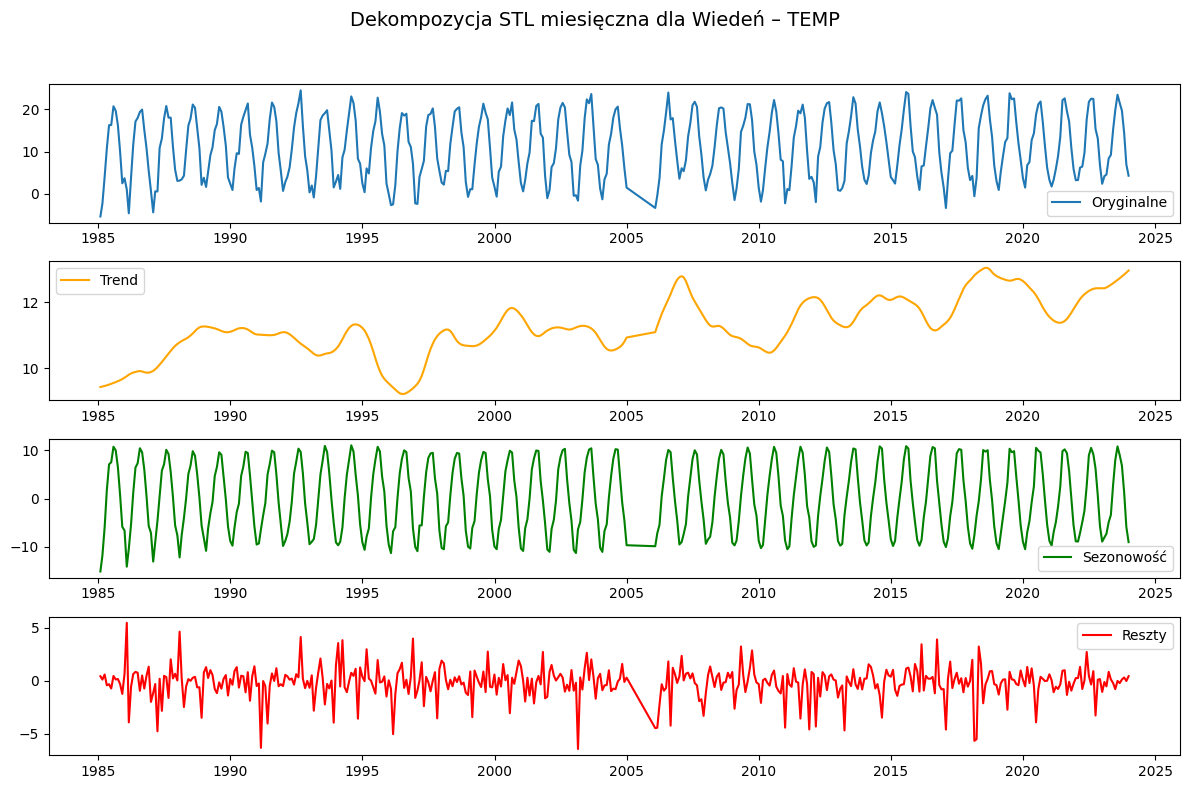

In [5]:
trends_temp = decompose_all_cities(cities, city_list, 'TEMP')

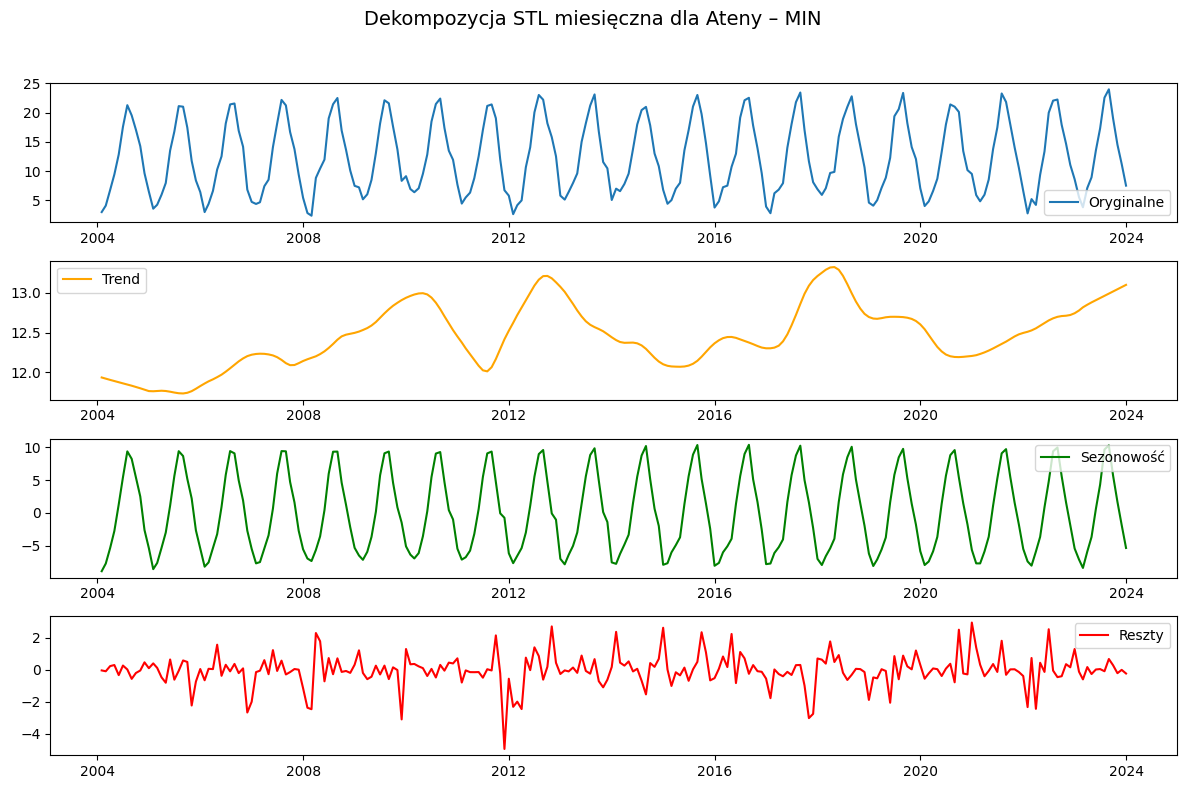

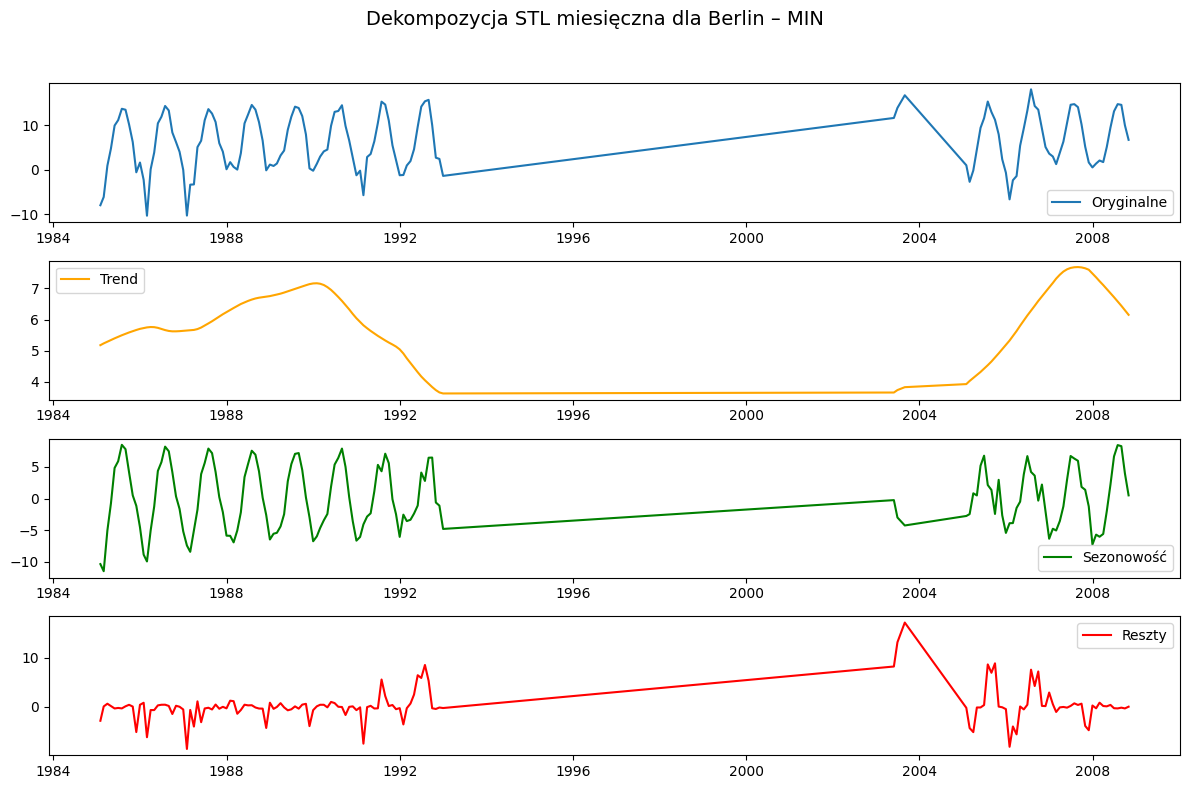

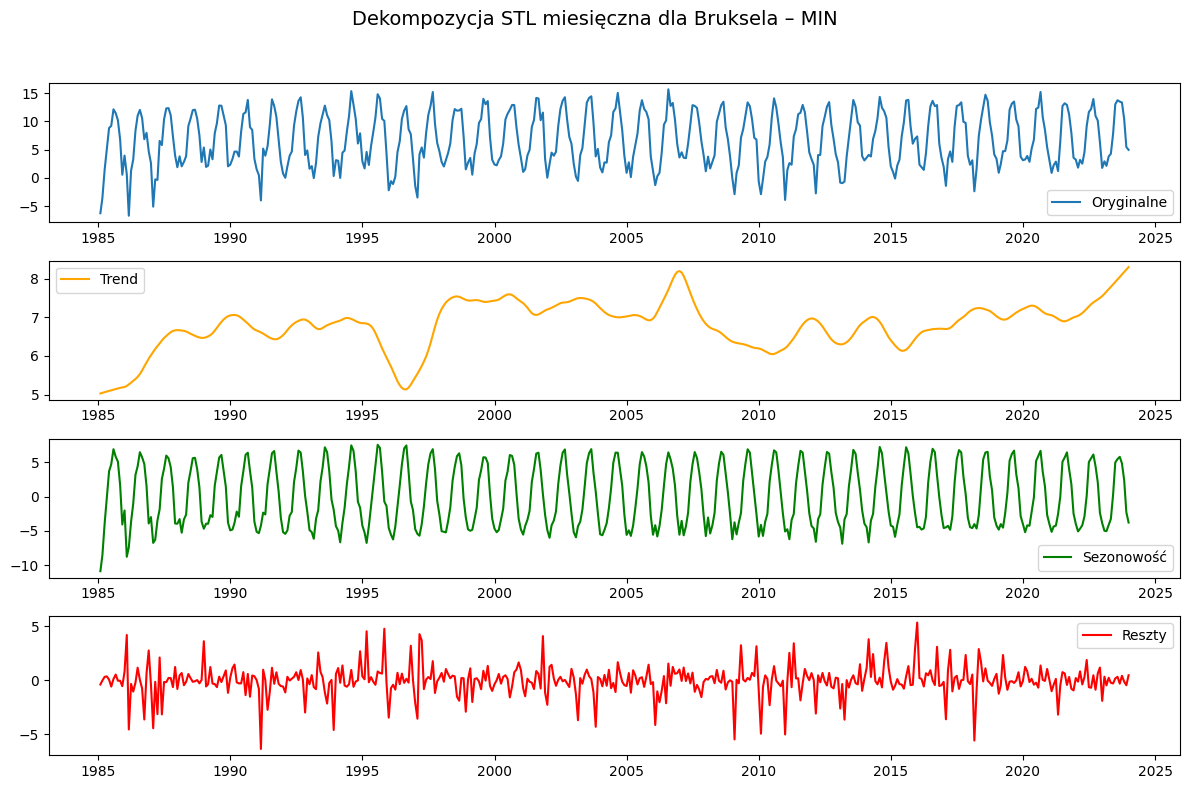

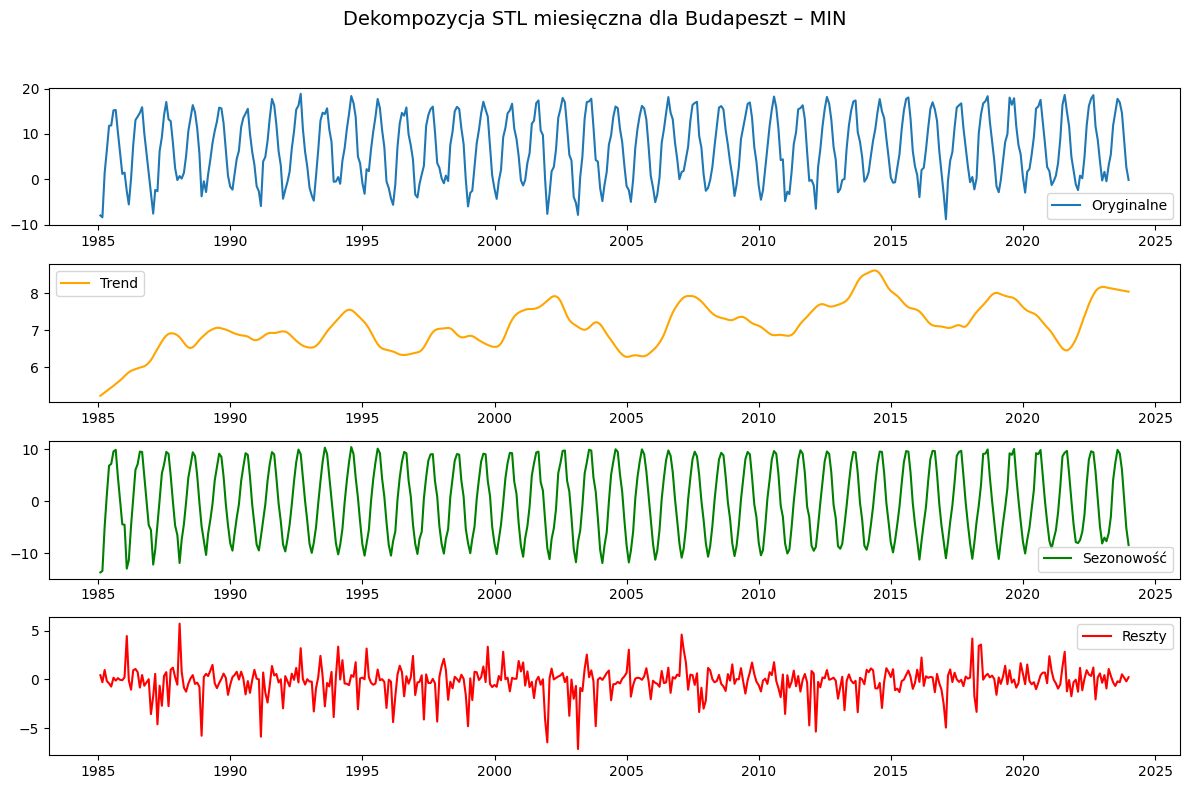

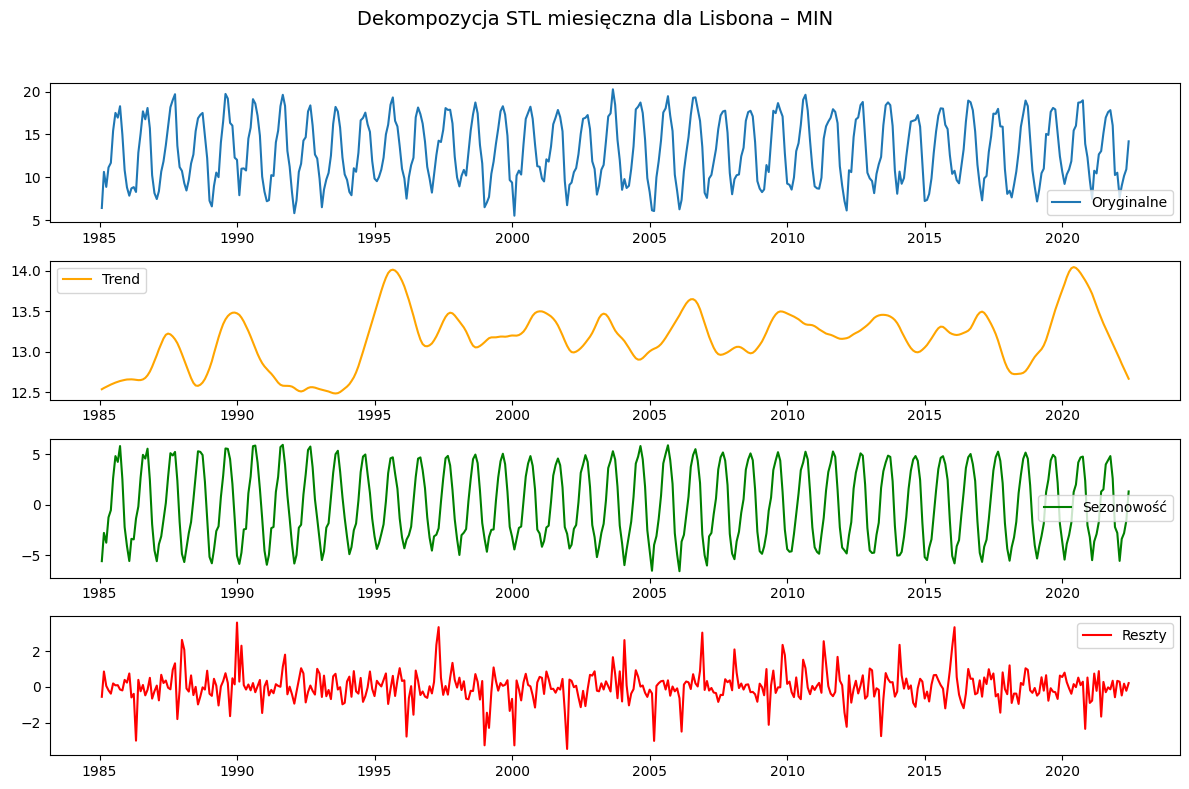

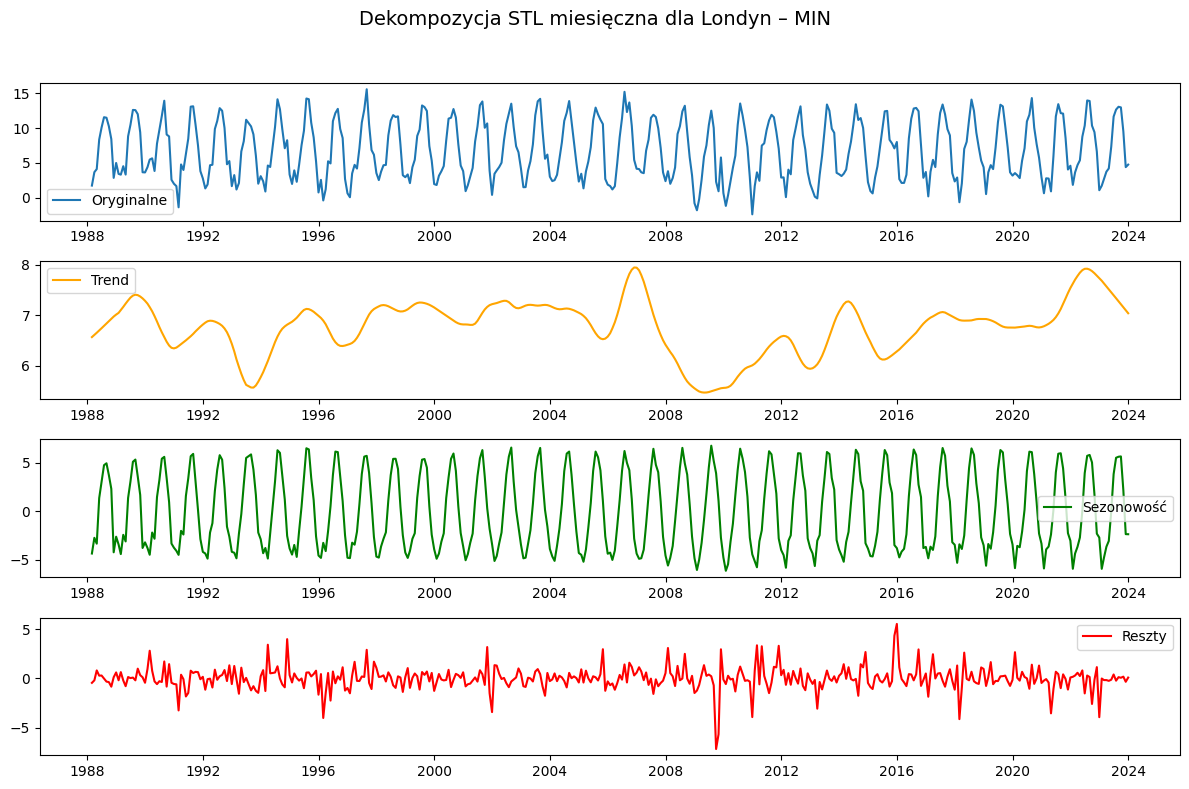

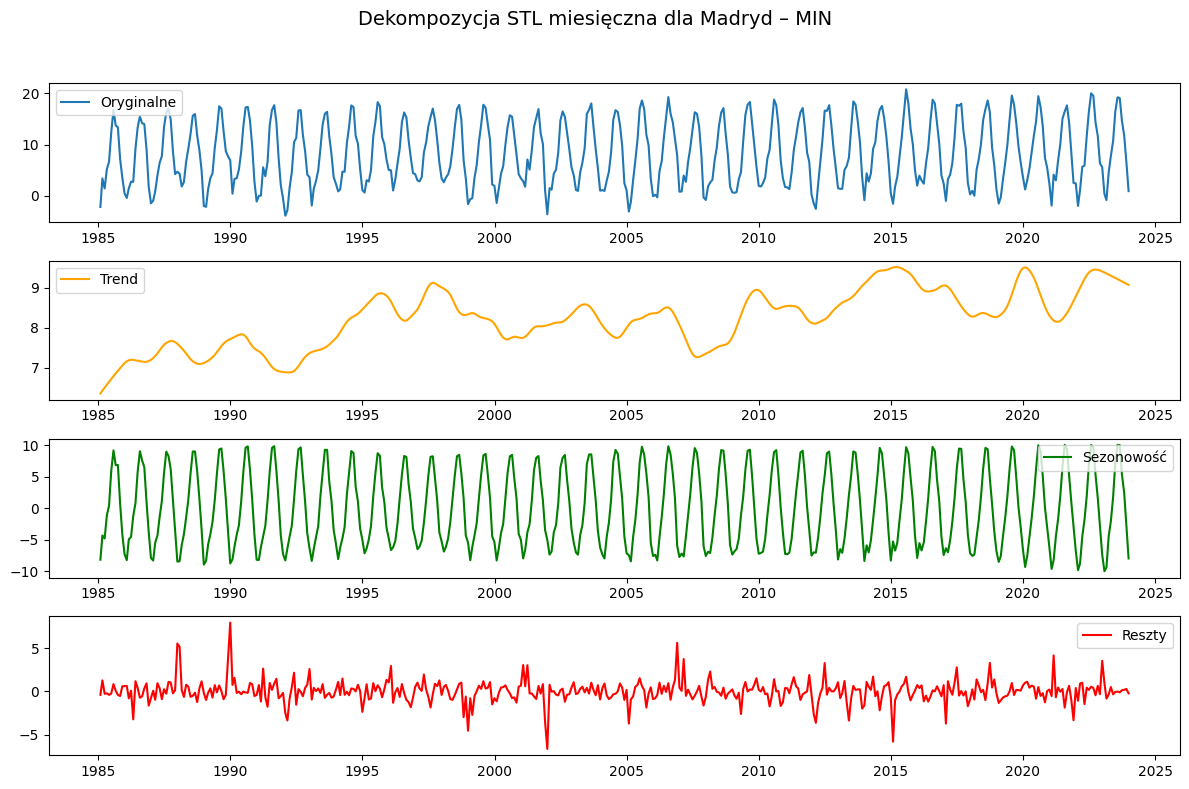

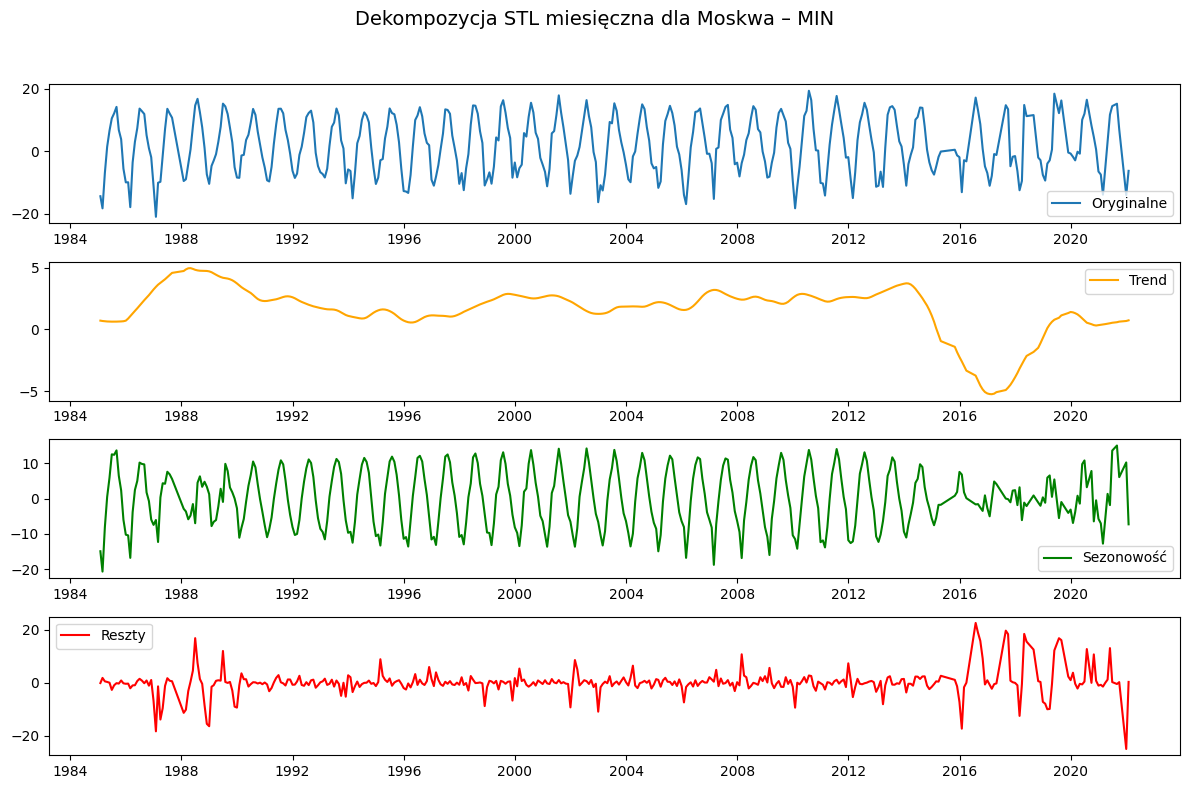

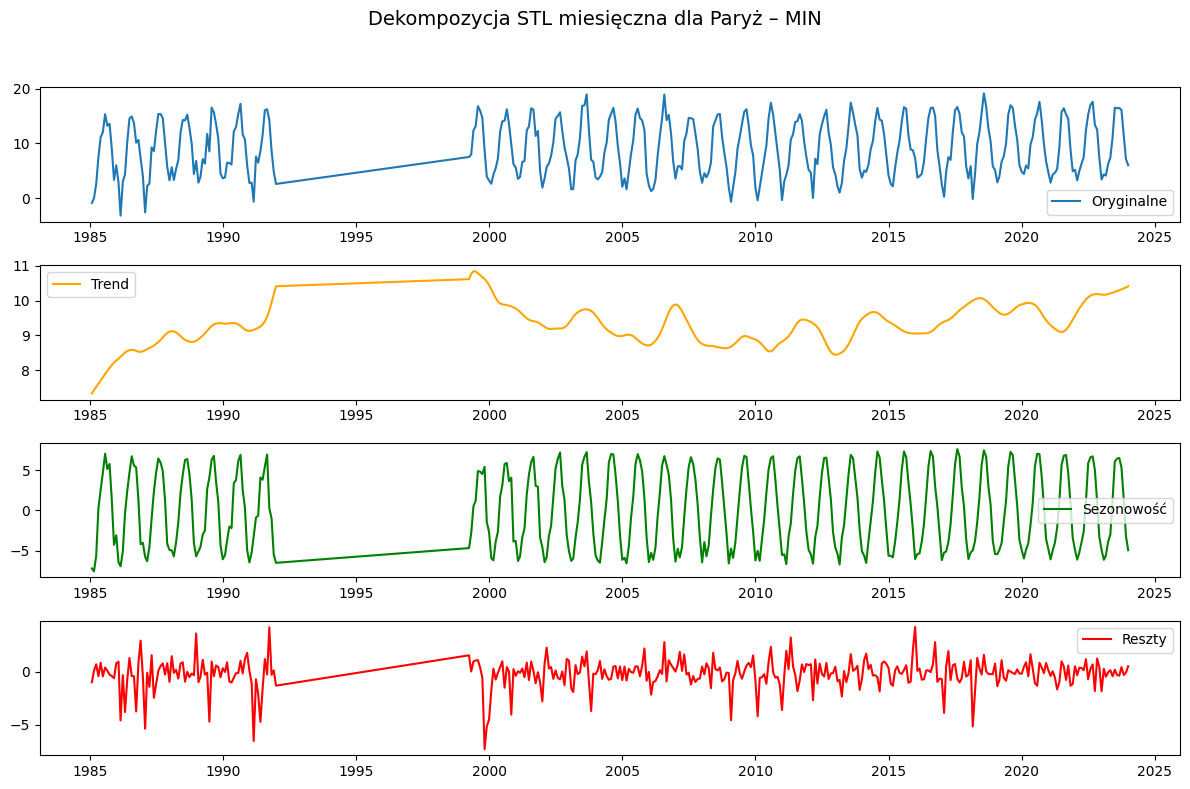

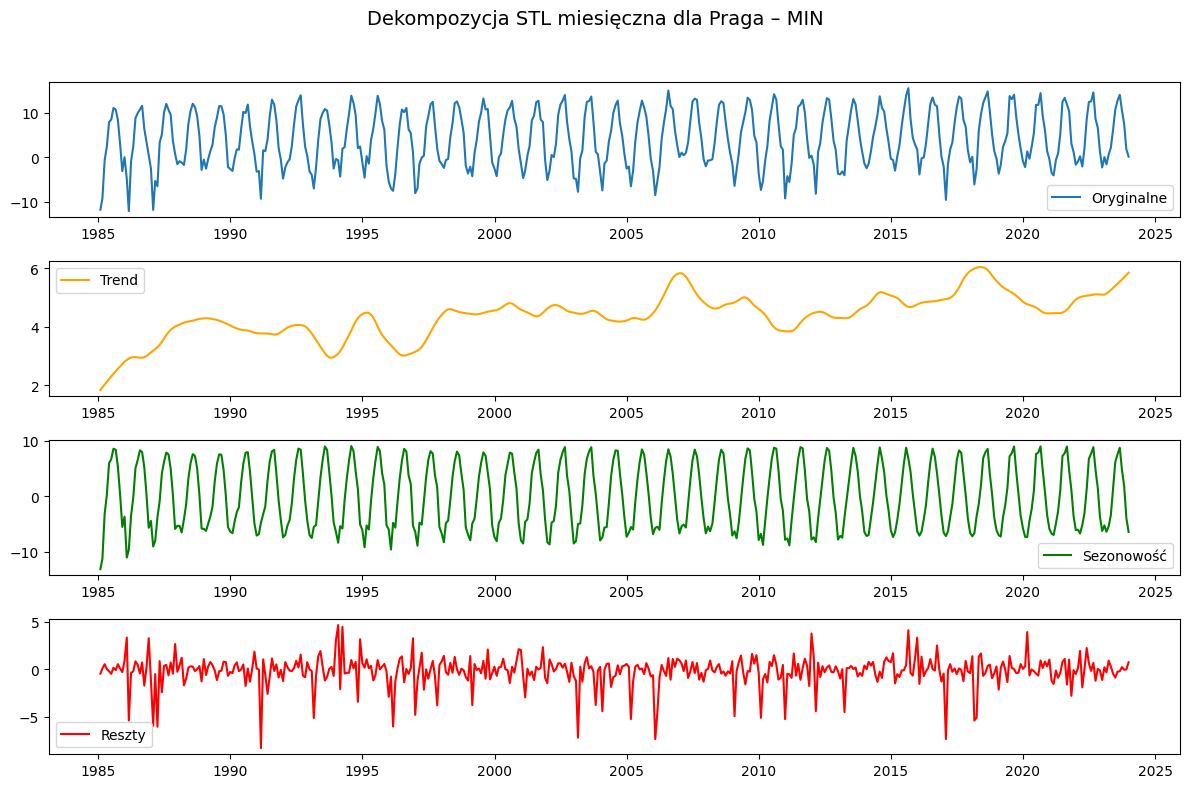

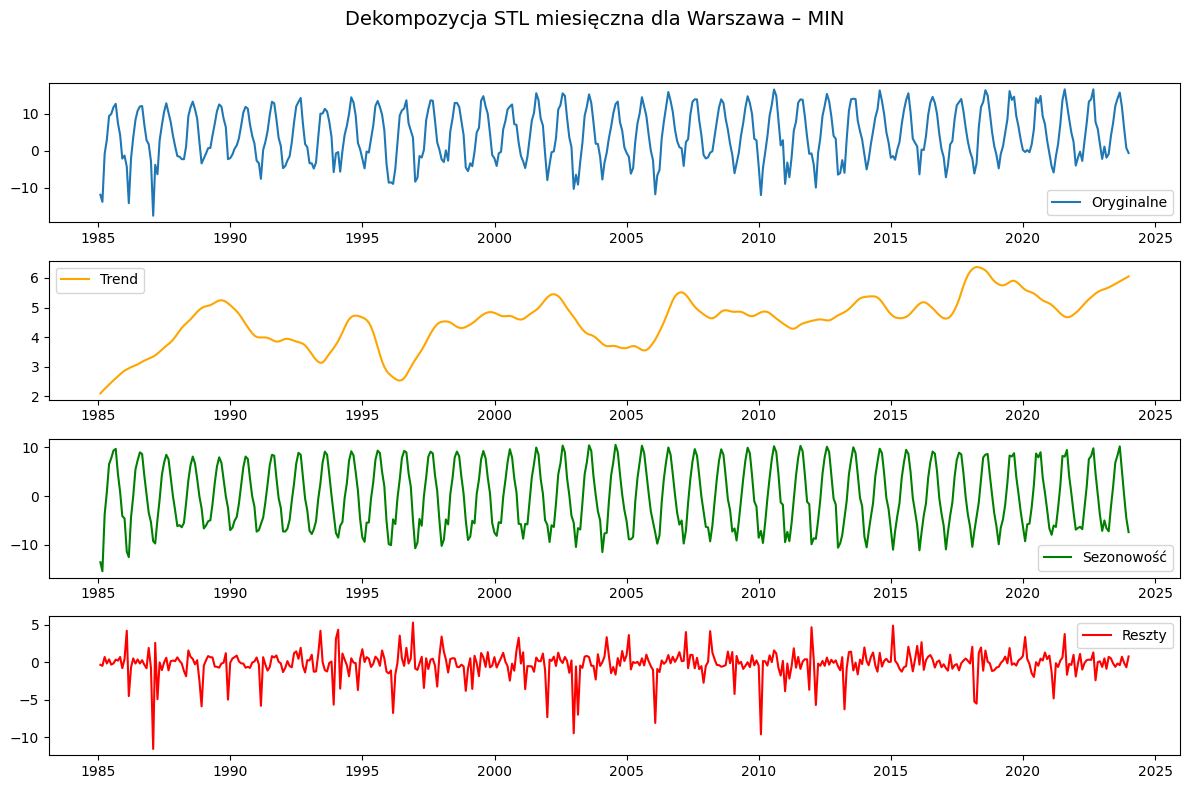

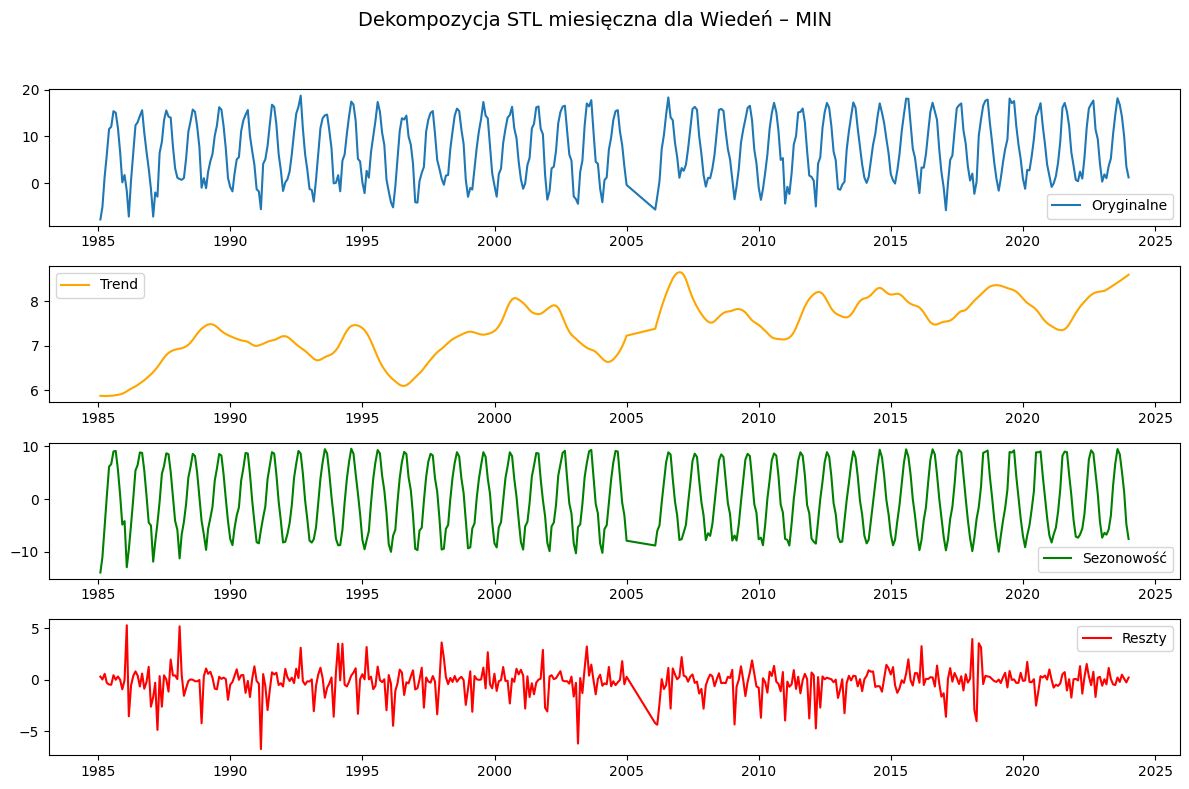

In [6]:
trends_min = decompose_all_cities(cities, city_list, column='MIN')

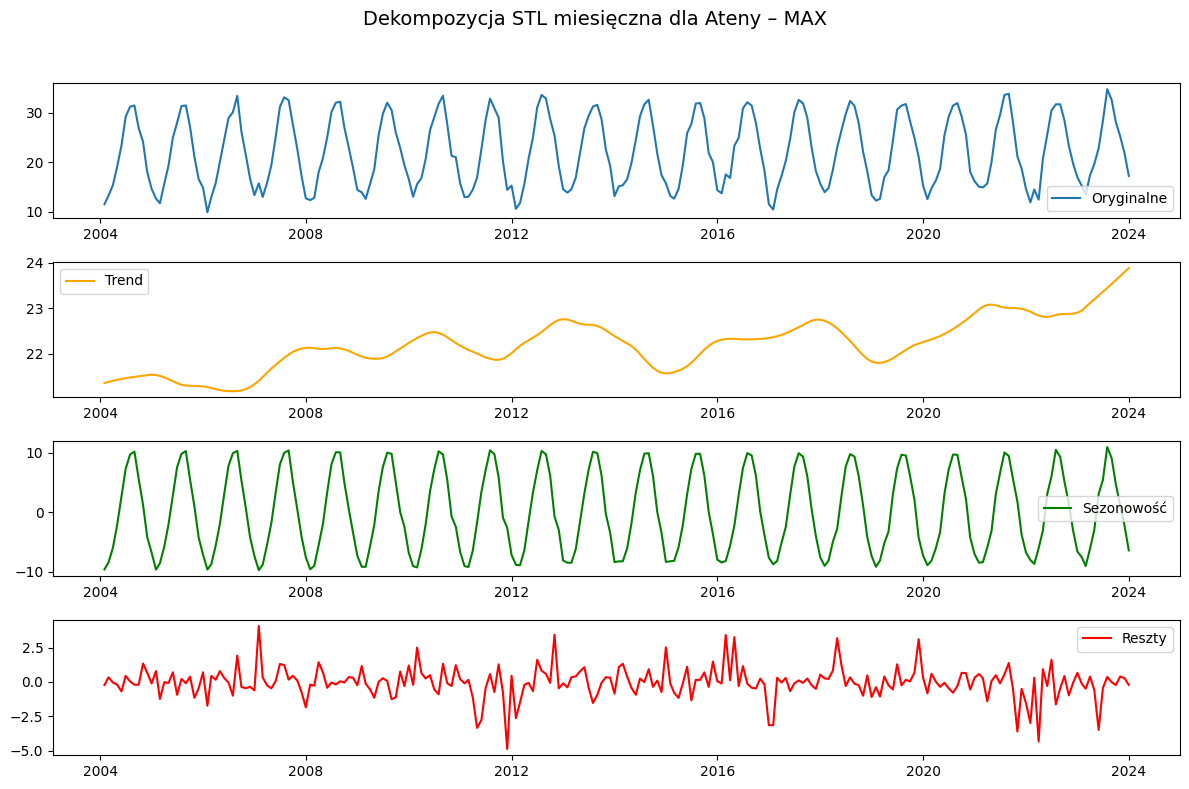

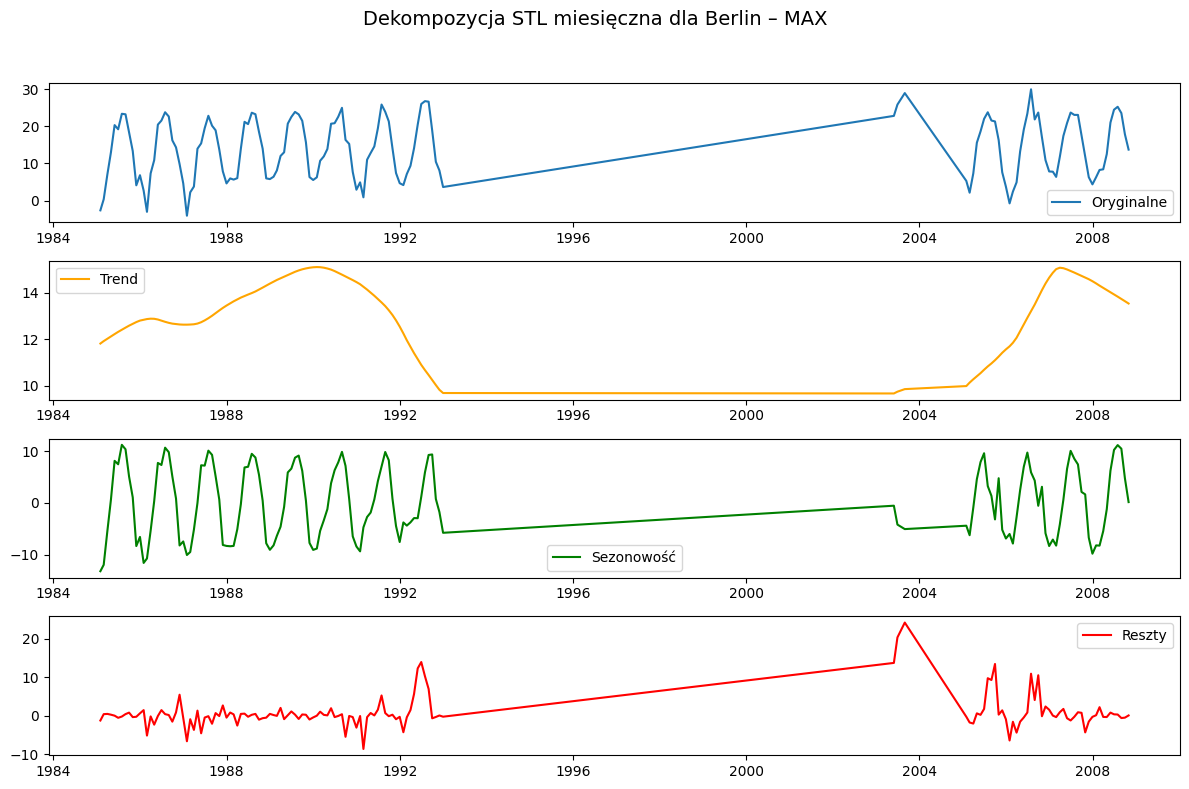

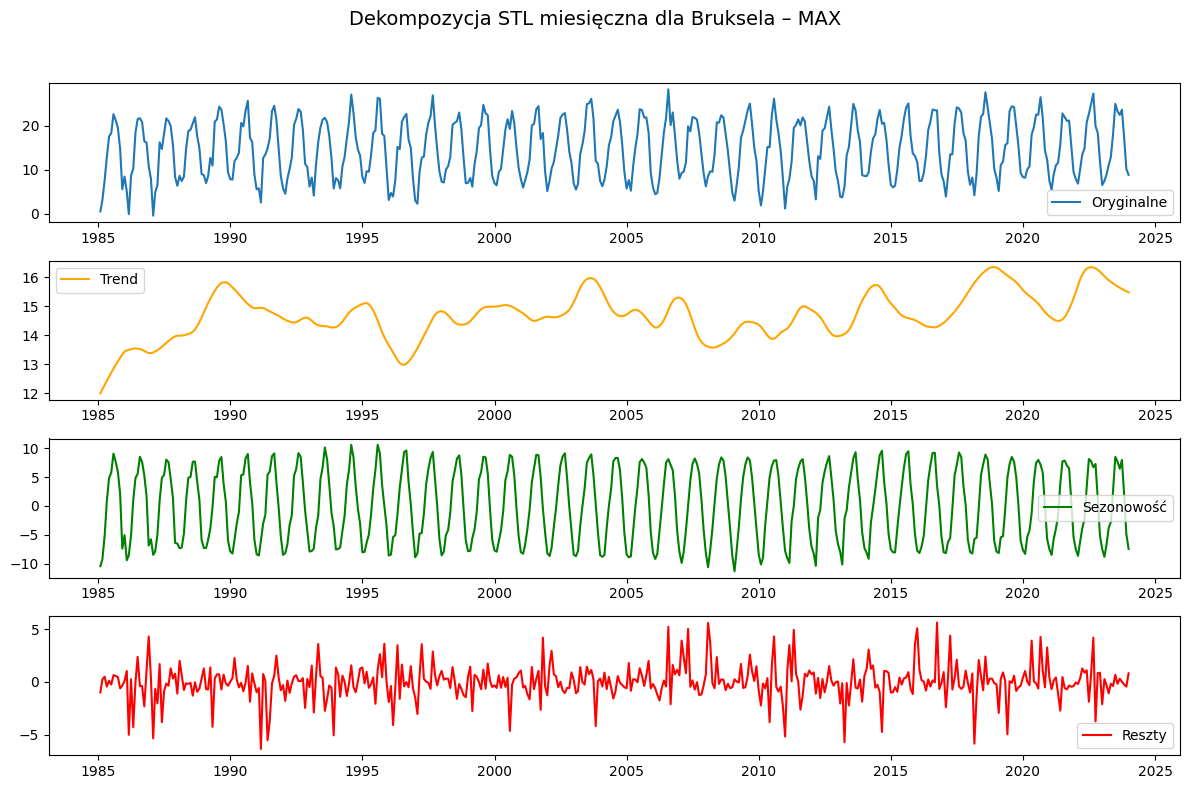

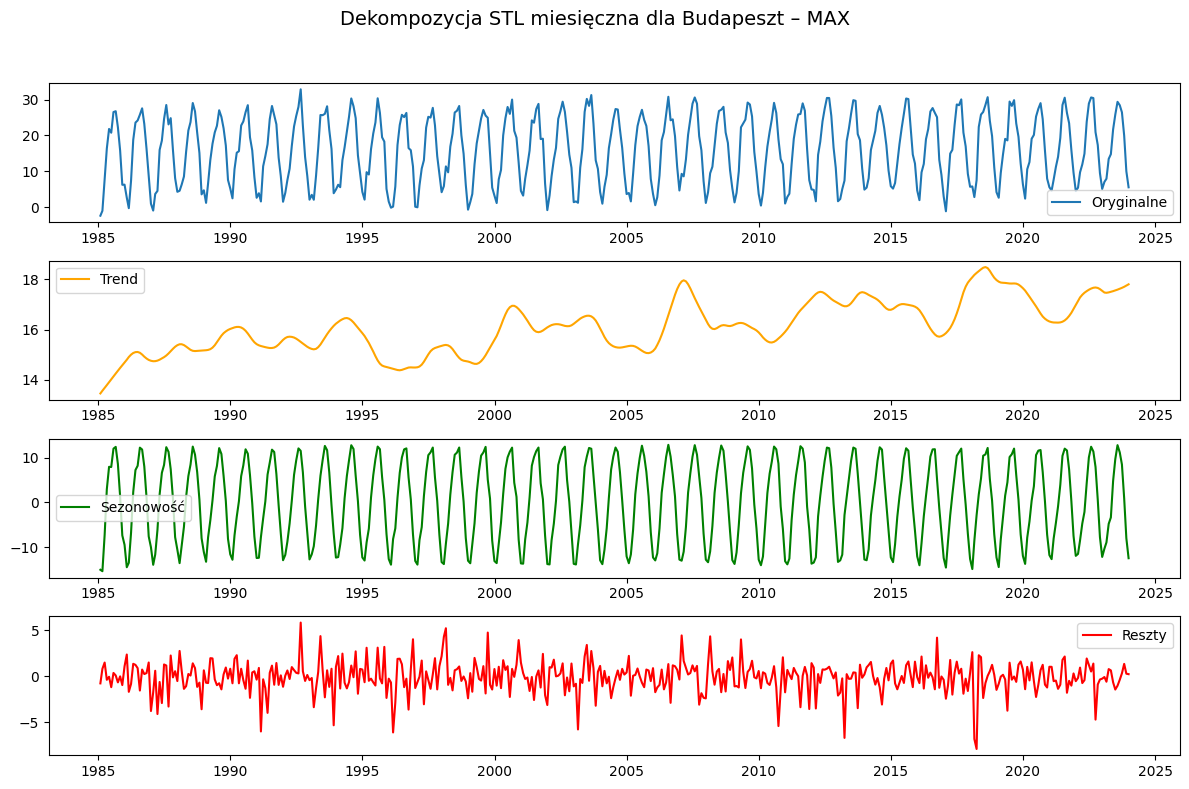

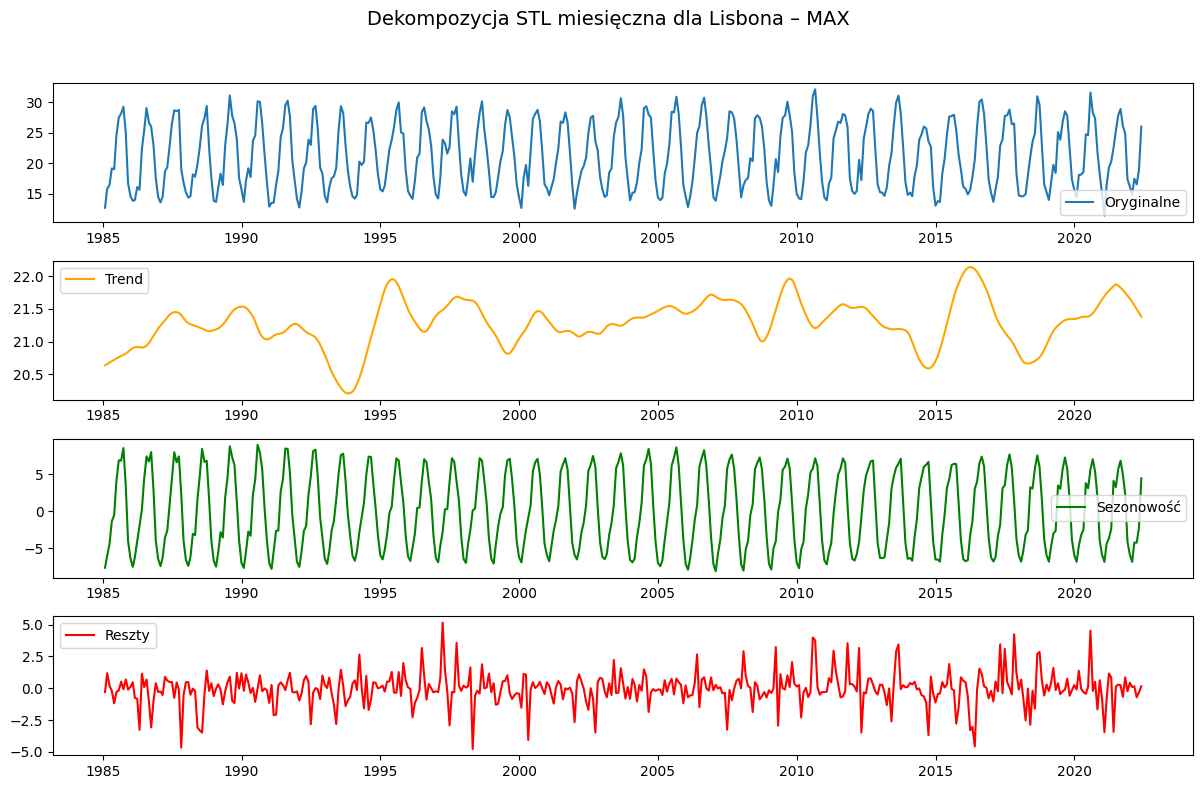

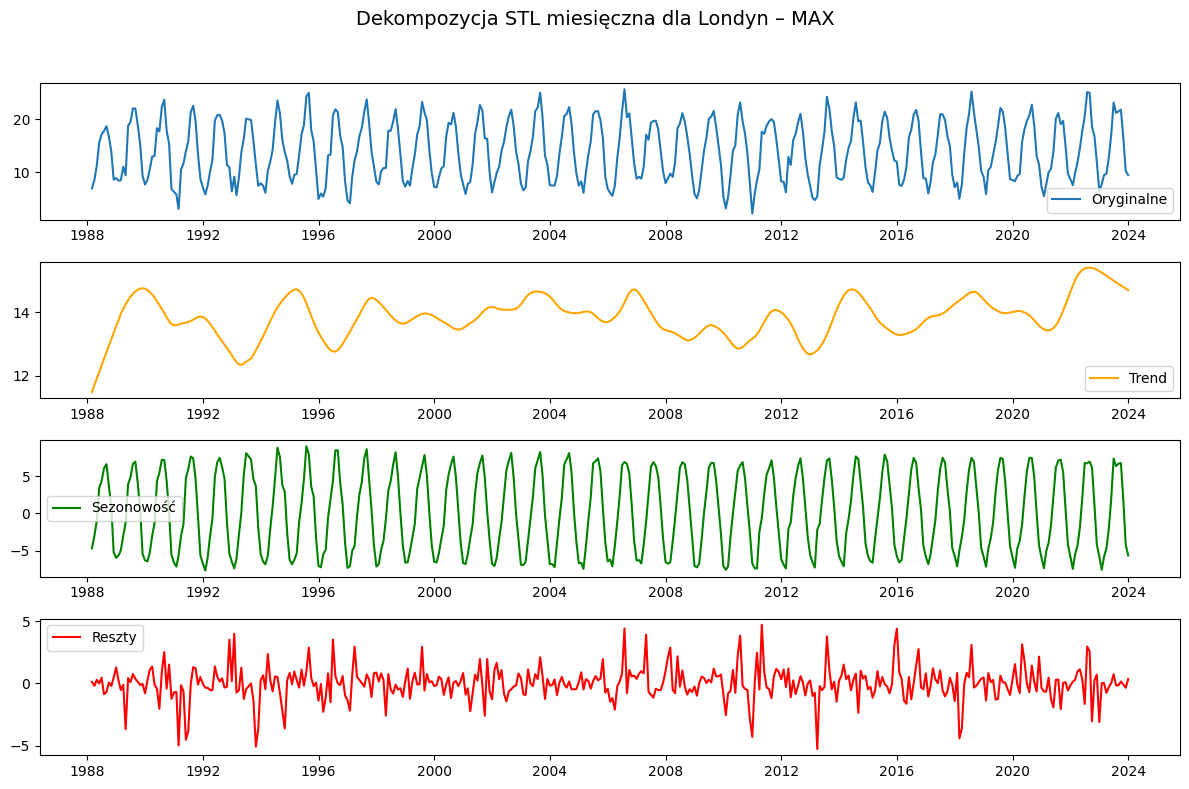

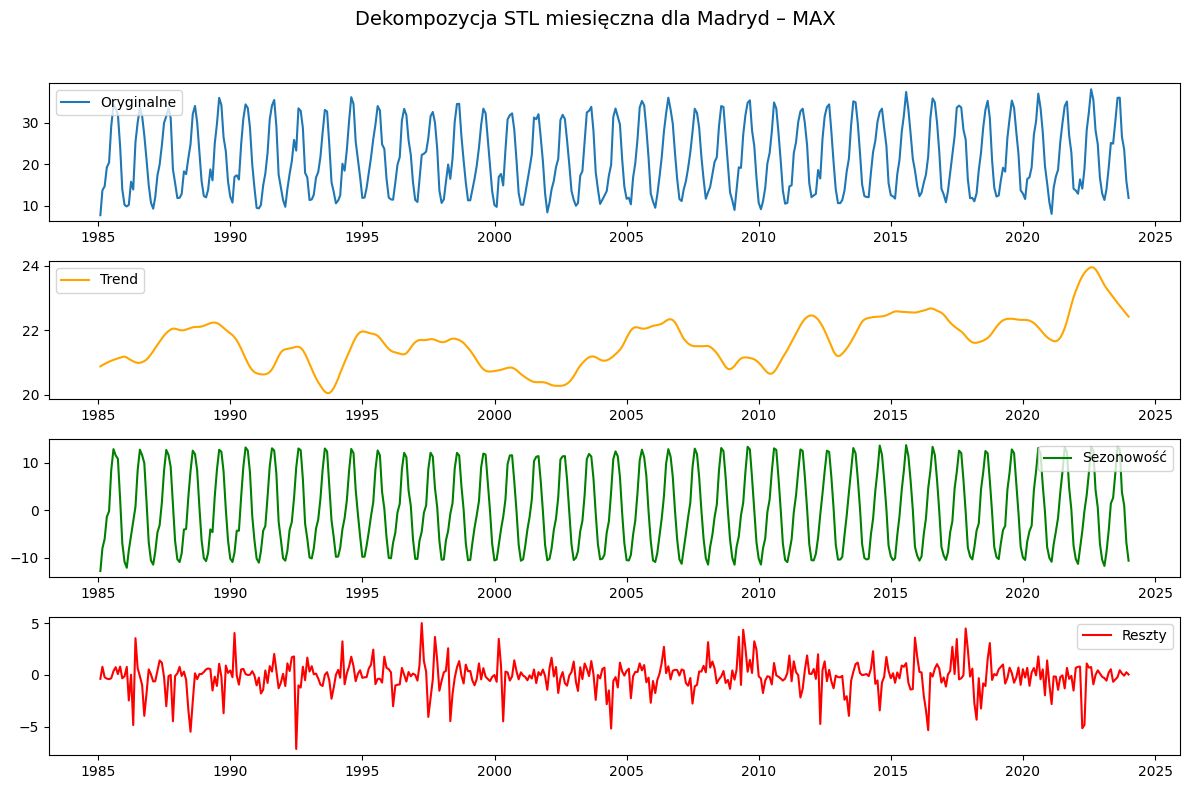

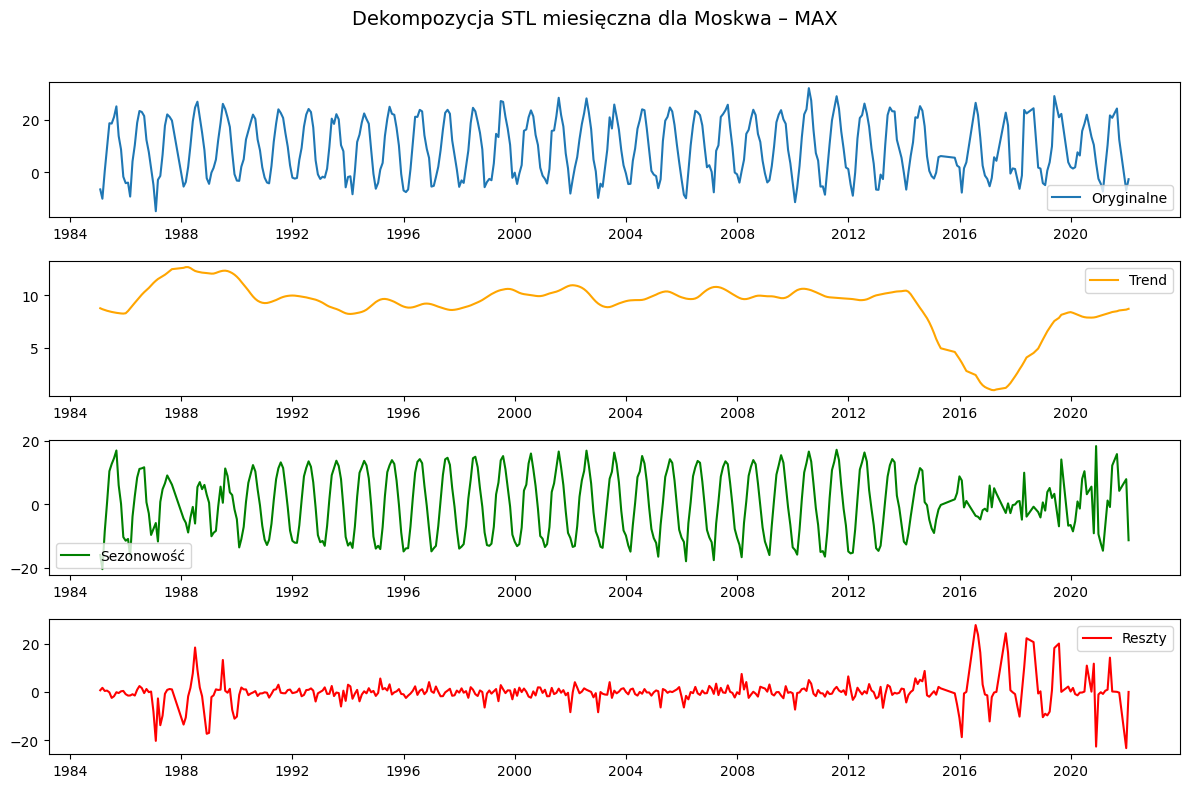

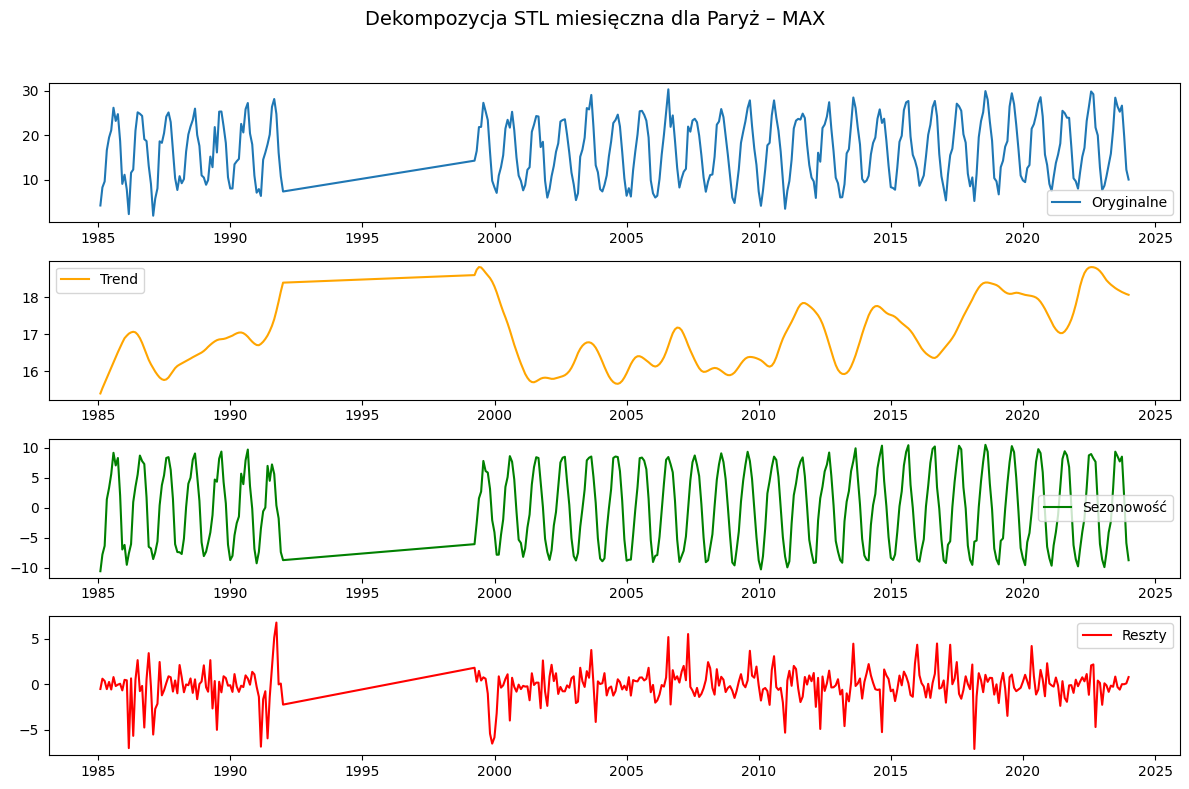

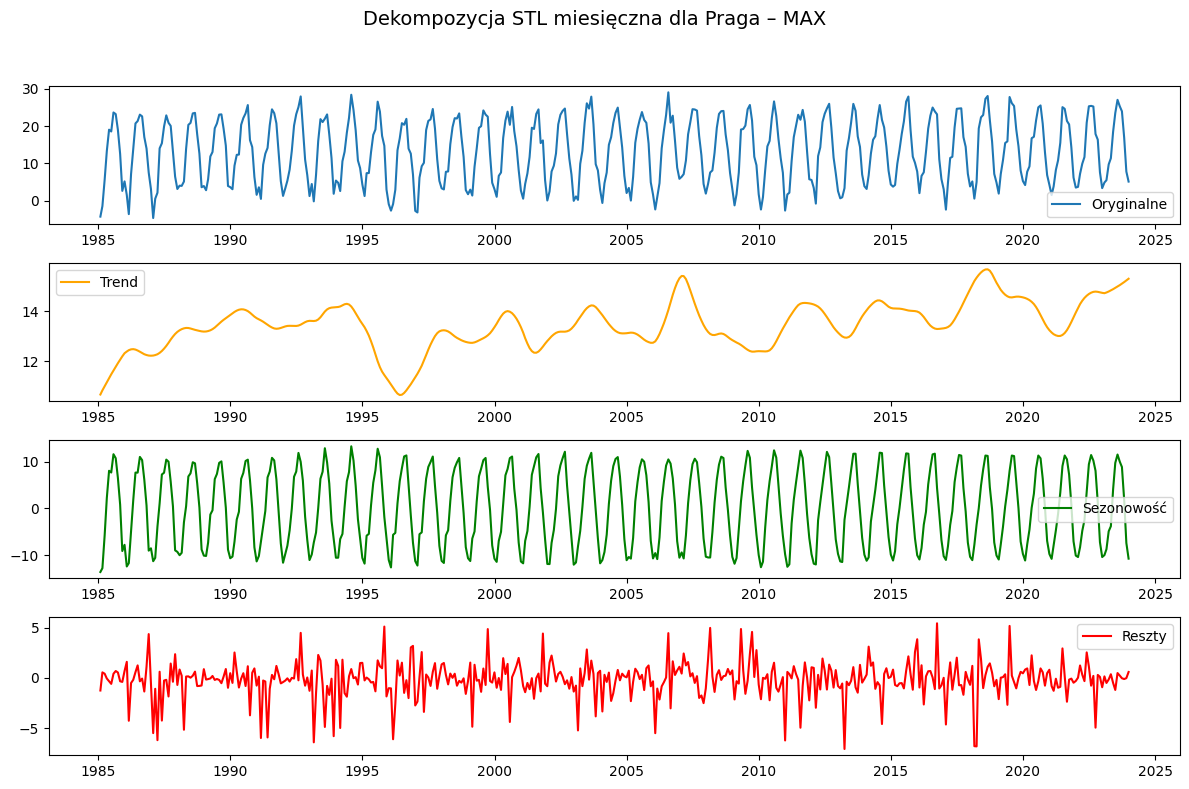

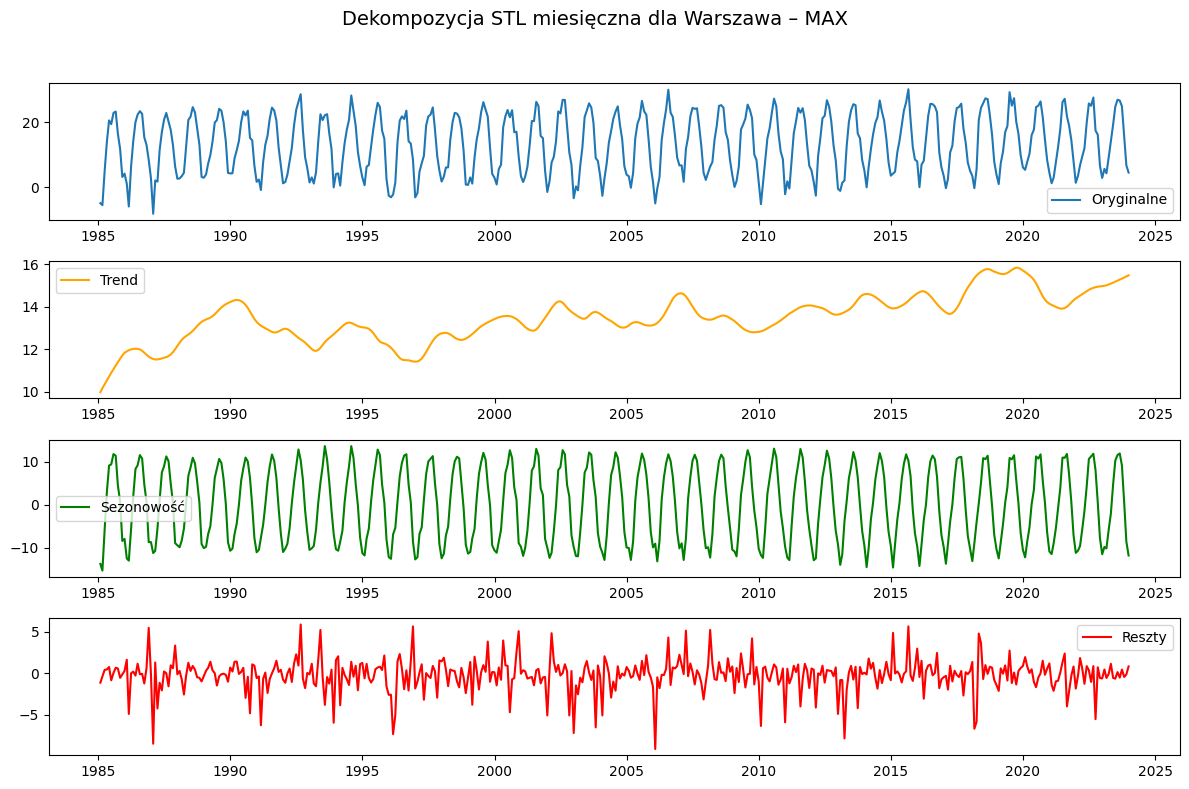

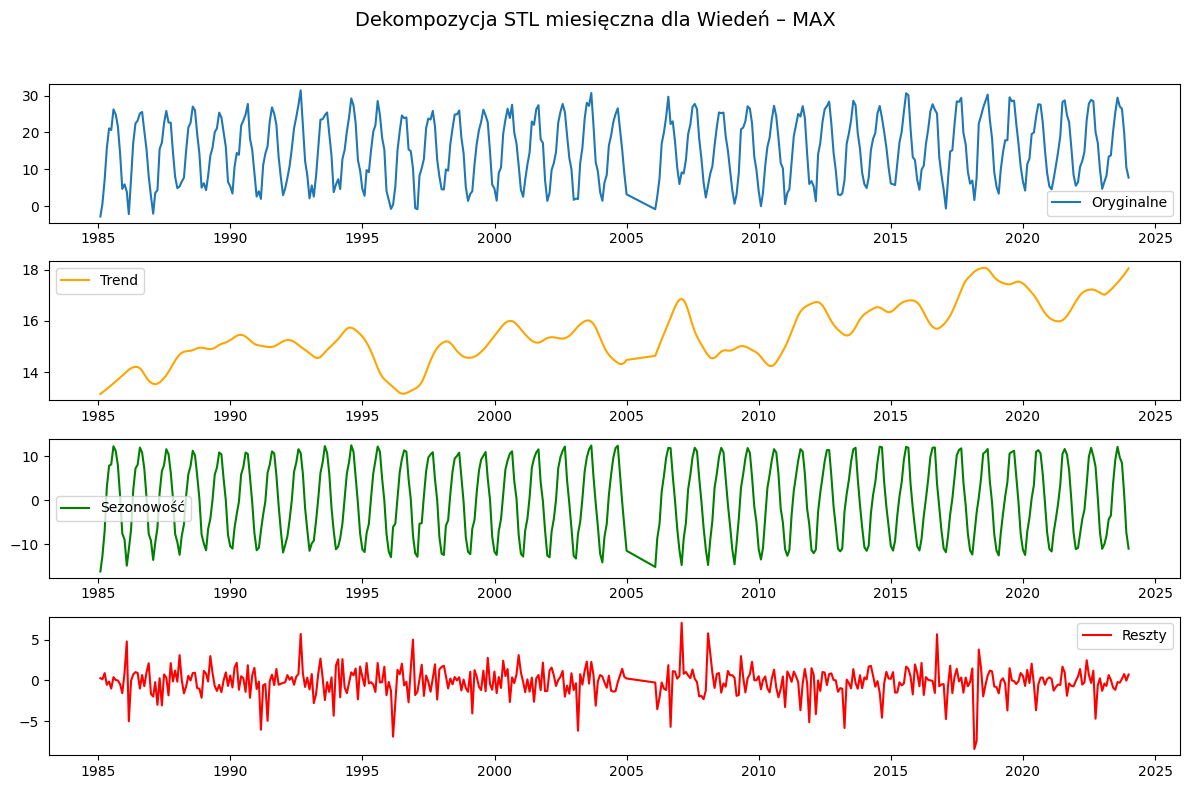

In [7]:
trends_max = decompose_all_cities(cities, city_list, 'MAX')

In [8]:
def plot_trends(trends_temp, trends_max, trends_min, city_list):
    palette = sns.color_palette("tab20", n_colors=len(city_list))

    # Funkcja pomocnicza do rysowania trendów
    def plot_single_trend(trends_dict, title):
        plt.figure(figsize=(12, 6))
        for i, city in enumerate(city_list):
            if city in trends_dict:
                trend = trends_dict[city]
                plt.plot(trend.index, trend.values, label=city, color=palette[i])
        plt.title(title)
        plt.xlabel('Rok')
        plt.ylabel('Trend')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Wykresy osobno
    plot_single_trend(trends_temp, 'Trend średniej temperatury (TEMP)')
    plot_single_trend(trends_max, 'Trend maksymalnej temperatury (MAX)')
    plot_single_trend(trends_min, 'Trend minimalnej temperatury (MIN)')

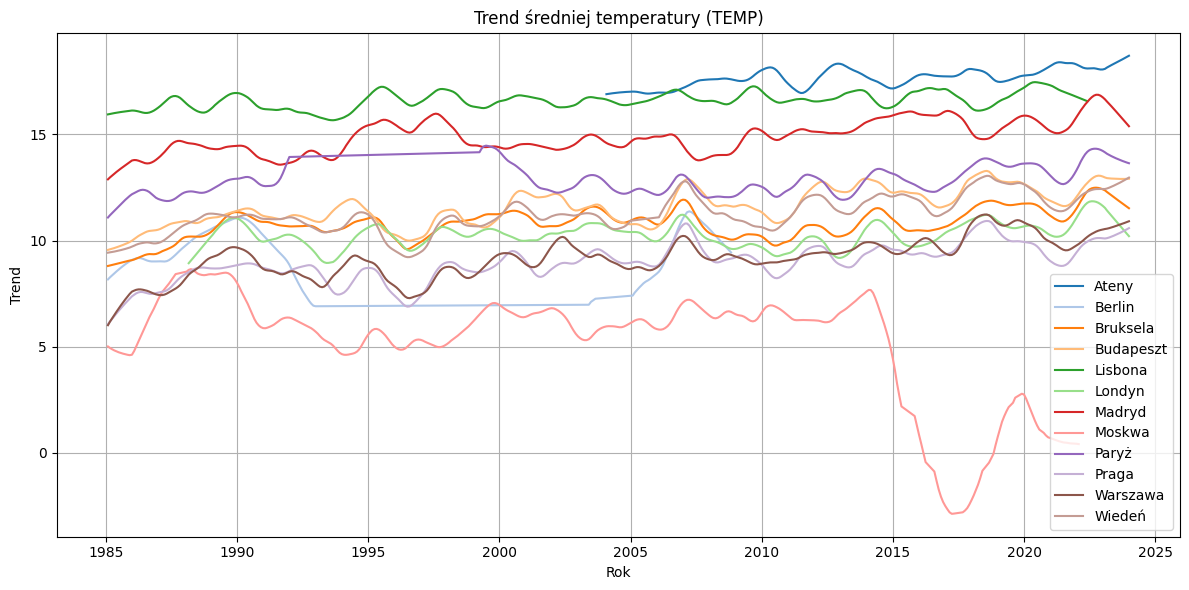

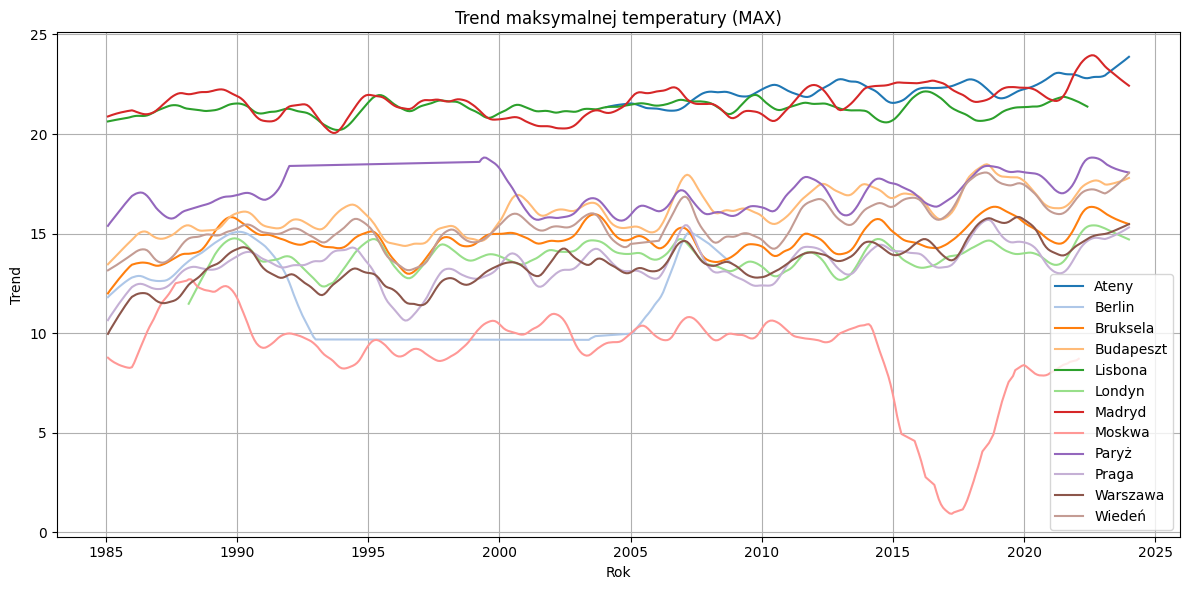

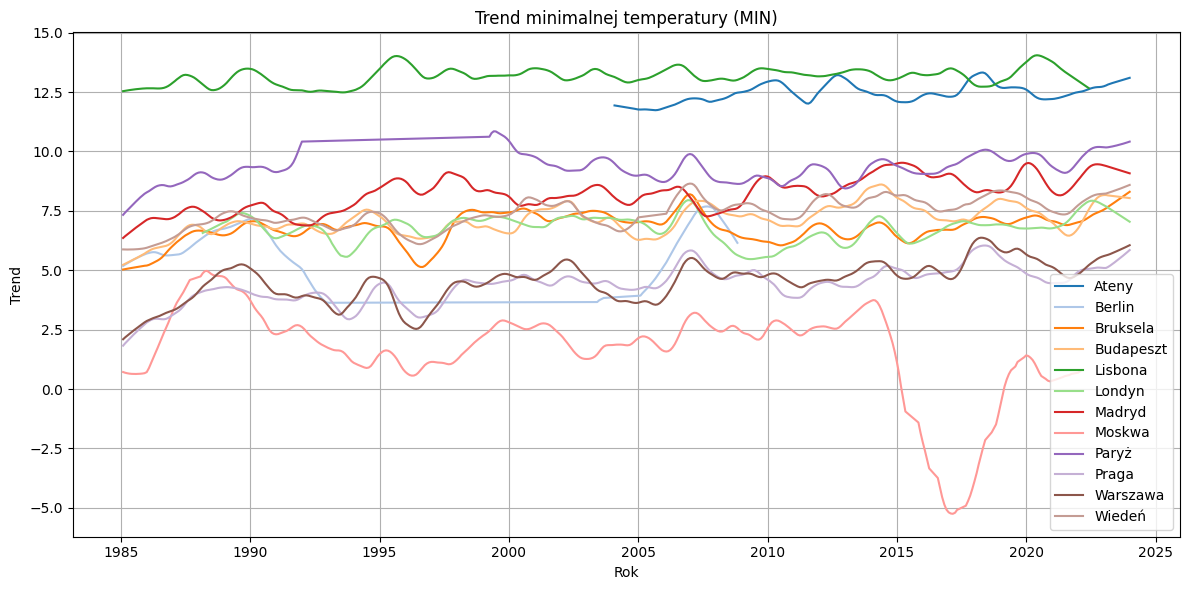

In [9]:
plot_trends(trends_temp, trends_max, trends_min, city_list)

In [10]:
def plot_weather_phenomena_trends(cities, city_list, phenomena):
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import statsmodels.api as sm

    palette = sns.color_palette("tab20", n_colors=len(city_list))
    trends = {pheno: {} for pheno in phenomena}

    for phenomenon in phenomena:
        plt.figure(figsize=(12, 6))

        for i, city in enumerate(city_list):
            df = cities[city].copy()
            df['DATE'] = pd.to_datetime(df['DATE'])
            df['YearMonth'] = df['DATE'].dt.to_period('M')

            monthly_counts = df.groupby('YearMonth')[phenomenon].sum()
            monthly_counts.index = monthly_counts.index.to_timestamp()

            x = np.arange(len(monthly_counts))
            y = monthly_counts.values

            if len(x) < 10:  # Zbyt mało danych do LOWESS
                continue

            # Dopasuj LOWESS
            lowess_smoothed = sm.nonparametric.lowess(y, x, frac=0.2, return_sorted=False)

            # Zapisz wynik do słownika
            trend_series = pd.Series(lowess_smoothed, index=monthly_counts.index)
            trends[phenomenon][city] = trend_series

            # Wykres
            plt.plot(monthly_counts.index, lowess_smoothed, label=city, color=palette[i])

        plt.title(f'Trend miesięcznej liczby dni z występowaniem: {phenomenon} (LOWESS)')
        plt.xlabel('Rok')
        plt.ylabel('Liczba dni w miesiącu')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return trends

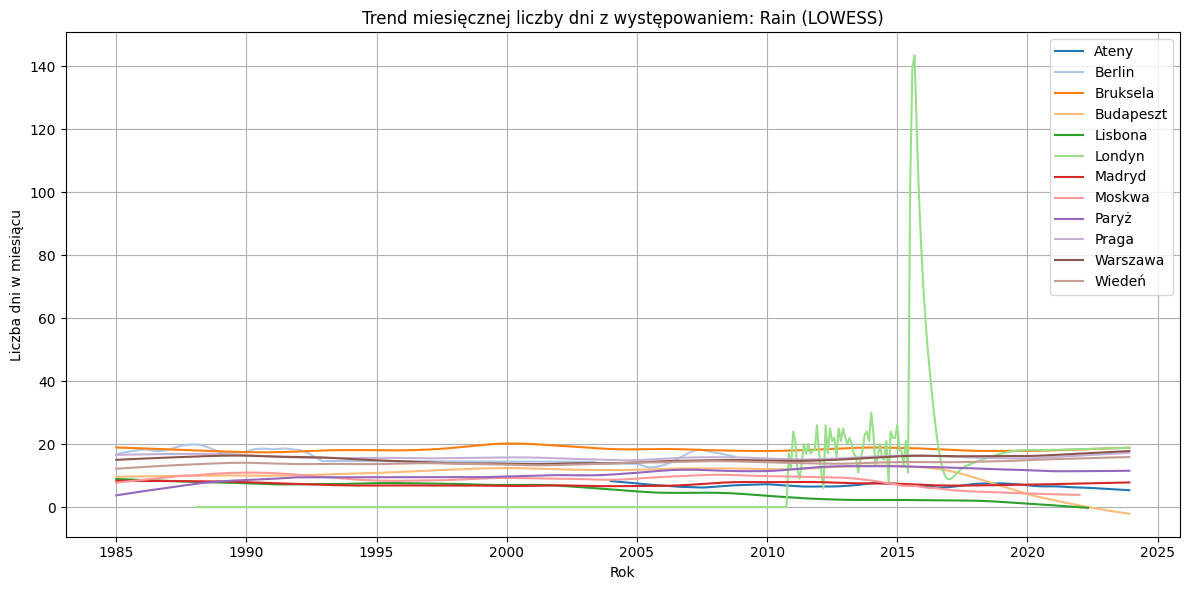

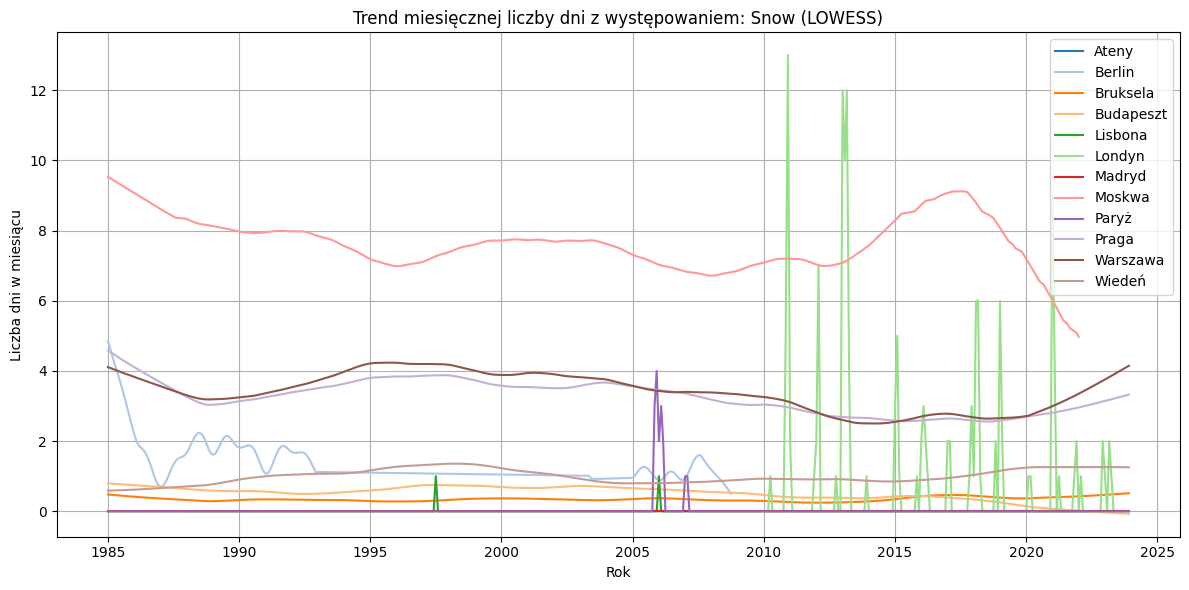

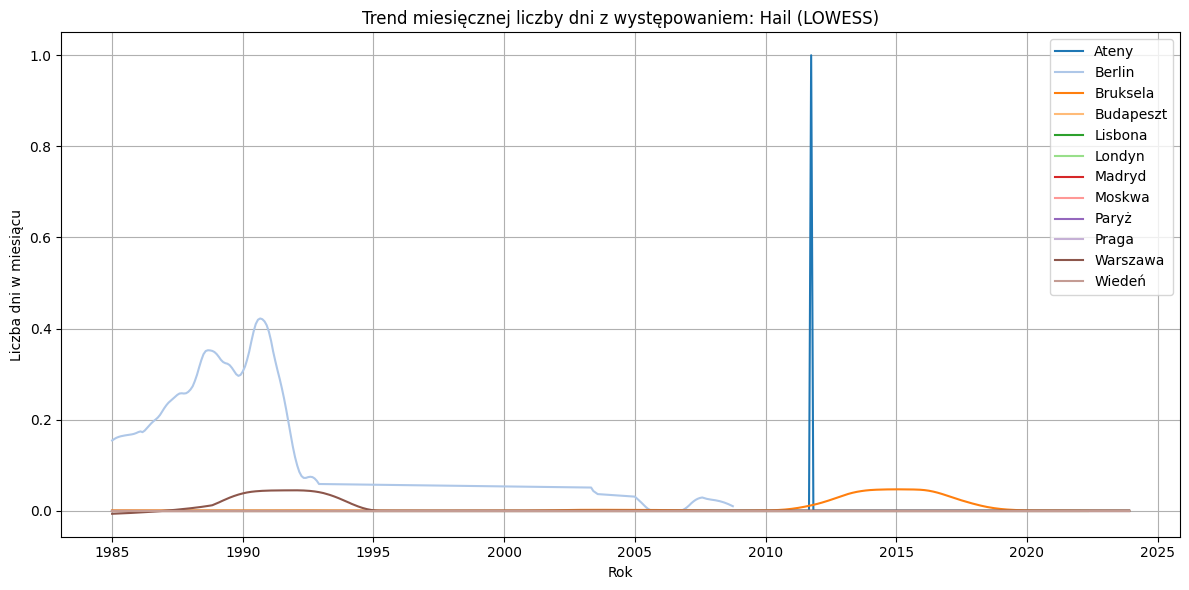

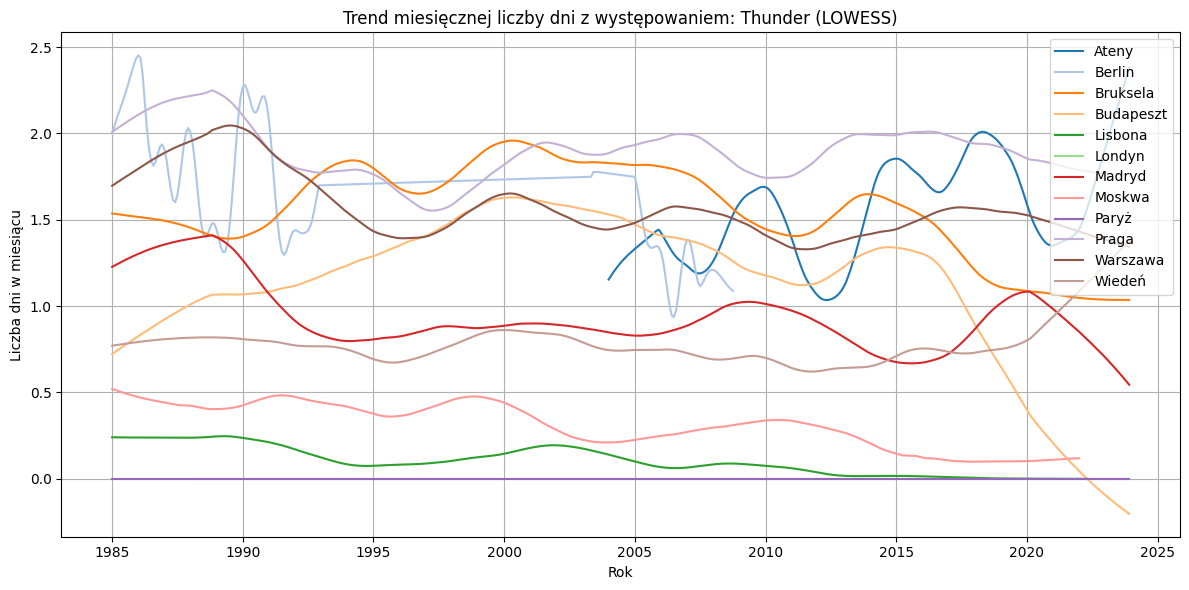

In [11]:
phenomena = ['Rain', 'Snow', 'Hail', 'Thunder']
trends_phenomena = plot_weather_phenomena_trends(cities, city_list, phenomena)

In [12]:
all_trends = {
    'temperature': {
        'TEMP': trends_temp,
        'MAX': trends_max,
        'MIN': trends_min
    },
    'phenomena': trends_phenomena
}

In [13]:
with open('../../data/all_trends.pkl', 'wb') as f:
    pickle.dump(all_trends, f)